# **Deep Learning project**
### Dog classification by their categories, including Golden retriver, Husky, Germany shepherd, Canis lupus , and Poodle 

Phase 0: Load data from google drive

In [ ]:
# Phase I
# mount drive from google drive
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
import tensorflow as tf 

from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dropout, Activation
from tensorflow.keras.layers import BatchNormalization

from keras.regularizers import l2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# no idea why it happens:
#       IOError: Image File is truncated
# after the PIL is imported, it is solved
# maybe version conflicts
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


path = '/content/drive/My Drive/DL/DOG' 
image_width, image_height = 256,256

## Count files and plot images distribution of each category, finally show some sample files

Folder name  train
Folder name  valid
Folder name  test
Total images =  3176


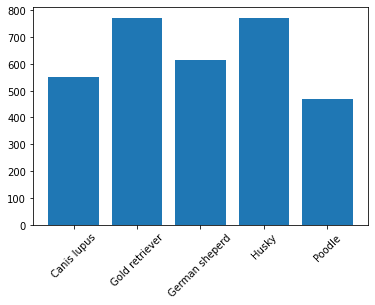

In [ ]:

# count total images in the dataset
def count_total_image(path):
    num = 0
    for d in os.listdir(path):
        print("Folder name ", d)
        for files in os.listdir(path+"/"+d):
            for f in os.listdir(path+'/'+d+'/'+files):
                num += 1
    print("Total images = ", num)

# scan directories and display their distribution of each dog categories
def get_distribution_images(path):
    dirs = os.listdir(path+'/train')
    directories = ['Canis lupus','Gold retriever','German sheperd','Husky','Poodle']
    directories_name=['cl','gr','gs','h','p']
    directories_map = {'cl':'Canis lupus', 'gr':'Gold retriever','gs':'German sheperd','h':'Husky','p':'Poodle'}
    fileamount = {}
    for folder in directories_name:
        fileamount[folder] = 0
        for directoryName in os.listdir(path+'/train'):
            if directoryName == folder:
                temp = path+'/train/'+directoryName
                fileamount[folder] += len(os.listdir(temp))
        for directoryName in os.listdir(path+'/test'):
            if directoryName == folder:
                temp = path+'/test/'+directoryName
                fileamount[folder] += len(os.listdir(temp))
        for directoryName in os.listdir(path+'/valid'):
            if directoryName == folder:
                temp = path+'/valid/'+directoryName
                fileamount[folder] += len(os.listdir(temp))
    plt.xticks(rotation=45)
    plt.bar([directories_map[x] for x in fileamount.keys()], fileamount.values())


    plt.show()

count_total_image(path)
get_distribution_images(path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


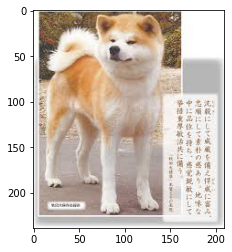

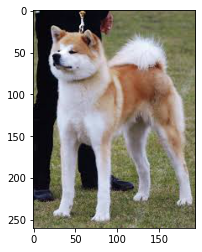

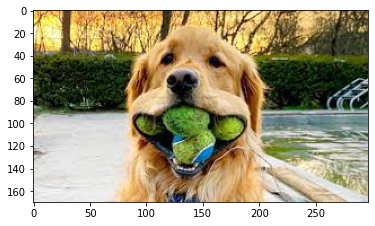

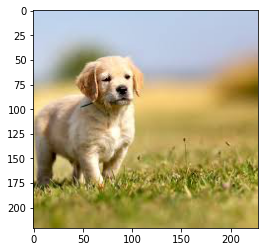

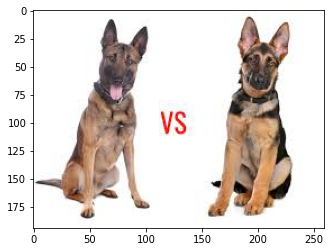

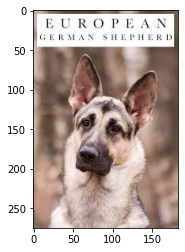

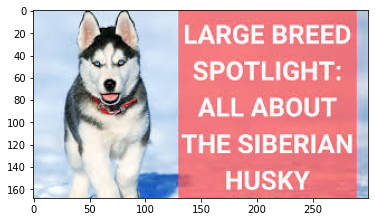

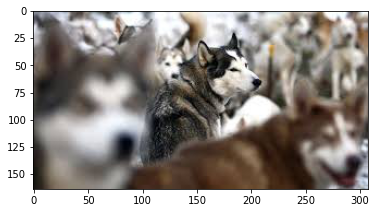

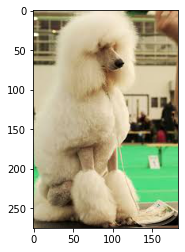

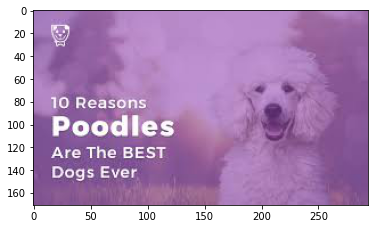

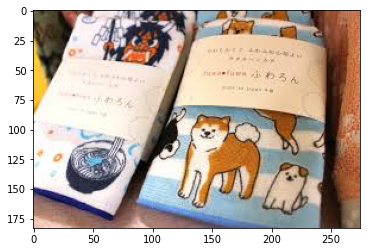

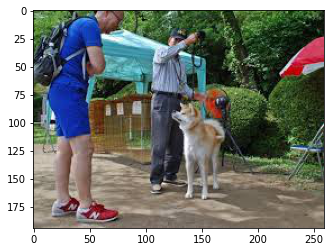

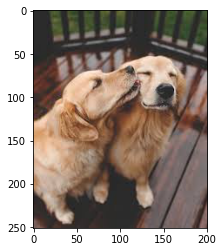

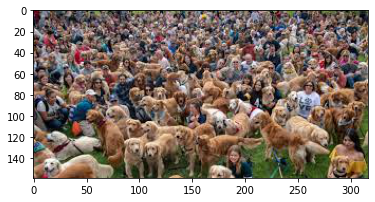

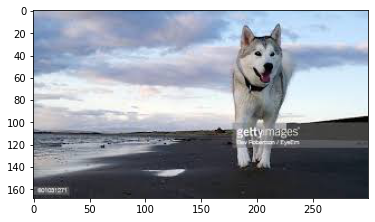

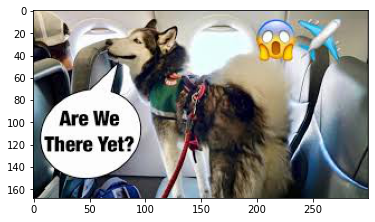

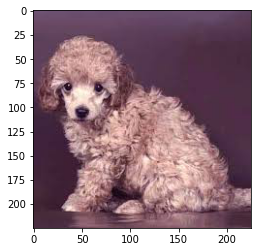

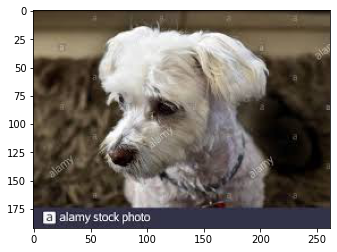

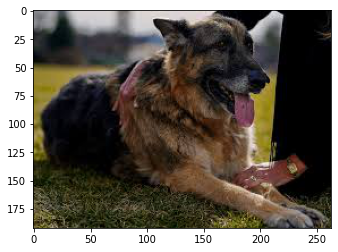

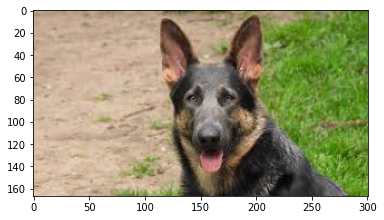

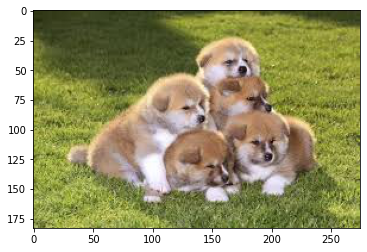

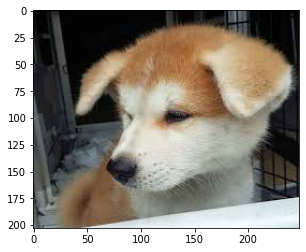

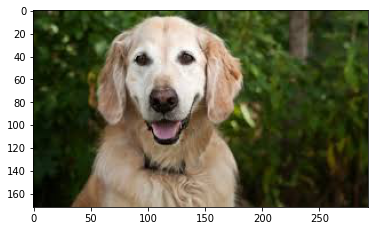

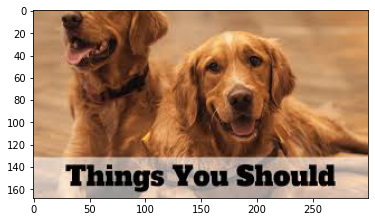

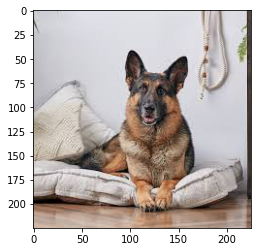

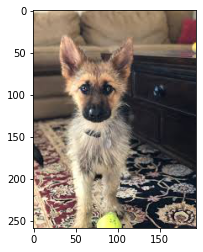

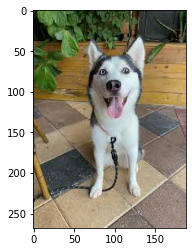

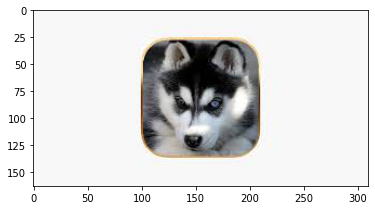

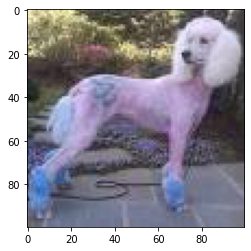

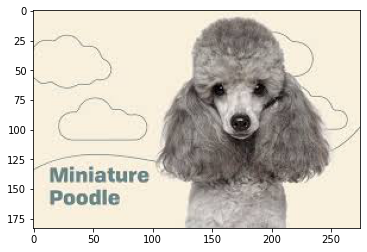

In [ ]:

# this function is from https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images
def process(filename: str=None) -> None:
    image = mpimg.imread(filename)
    plt.figure()
    plt.imshow(image)


path = '/content/drive/My Drive/DL/DOG' 

# show two image in each folders
def show_sample_images(path):
    files = os.listdir(path)
    for directoryName in files:
        temp = path+'/'+directoryName
        for dir in os.listdir(temp):
            i = 0
            for file in os.listdir(temp+'/'+dir):
                process(temp+'/'+dir+'/'+file)
                i += 1
                if i >= 2:
                    break
            i = 0
show_sample_images(path)

In [ ]:
# this section merge all data into one folder, for the overfitting section
path0 = path+'0/train'
des = path+'0/all/all'
# print(path0, des)
j = 0
for dir in os.listdir(path0):
    # print(dir)
    
    for file in os.listdir(path0+'/'+dir):
        file_name, file_extension = os.path.splitext(file)
        shutil.copy(path0+'/'+dir+'/'+file, des+'/'+str(j)+file_extension)
        j += 1
# print(j)

/content/drive/My Drive/DL/DOG0/train /content/drive/My Drive/DL/DOG0/all/all
cl
gr
gs
h
p
3176


In [ ]:
!ls '/content/drive/My Drive/DL/DOG/valid/cl' |wc -l

115


In [ ]:
!ls '/content/drive/My Drive/DL/DOG0/'


all  test  train


# Overfitting
## Required to train the whole dataset, some parameters are changed with all data.

In [ ]:
# path0 is the directory containing all images, duplicate in both train and valid folders, no data split in both
path0 = '/content/drive/My Drive/DL/DOG0/'


def get_train_generator(path, image_width, image_height):
    my_generator = ImageDataGenerator(rescale=1./255)
    train_generator = my_generator.flow_from_directory( path+'/train/', target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
    # valid_generator = my_generator.flow_from_directory( path+'/test/', target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
    return train_generator


# can not be bigger, otherwise the dimension becomes negative
def overfitting(train_generator, layers,image_width, image_height):
    model = Sequential()
    j = 0
    for i in range(len(layers)):
        if i == 0:
            model.add( Conv2D( layers[i], ( 3, 3 ), activation = 'relu' , input_shape = (image_width, image_height, 3)))
        else:
            model.add( Conv2D( layers[i], ( 3, 3 ), activation = 'relu'))
        i += 1
        # if maxpool2d is saved, the accuracy is pretty low in the project, so, in this step, it is skipped
        # model.add( MaxPool2D(2,2) )
    model.add( Flatten() )
    model.add( Dense( 5, activation = 'softmax' ) )
    model.summary()
    model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall() ] )
    # after testing several times, epochs = 10 is enough in this step
    history = model.fit( train_generator,  epochs = 10, batch_size = 64,verbose = 0 )

    return history

def plot_result(history, key1, title):
    plt.plot(history.history[key1])
    # list(history.history.keys())[2][:list(history.history.keys())[2].rfind('_')]
    plt.ylabel(str(key1)[:key1.rfind('_')])
    plt.xlabel('Epoch')
    plt.legend(['training data', ], loc='lower right')
    plt.title(title)
    plt.show()


def test_overfitting(path0, layers,image_width, image_height):
    train_generator = get_train_generator(path0,image_width, image_height)
    history = overfitting(train_generator, layers , image_width, image_height)
    plot_result(history, list(history.history.keys())[0], 'Learning Curve Loss')
    plot_result(history, list(history.history.keys())[1], 'Learning Curve Accuracy')
    plot_result(history, list(history.history.keys())[2], 'Learning Curve precision')
    plot_result(history, list(history.history.keys())[3], 'Learning Curve Recall')
    return history

Found 3176 images belonging to 5 classes.
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
flatten_20 (Flatten)         (None, 1032256)           0         
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 5161285   
Total params: 5,161,733
Trainable params: 5,161,733
Non-trainable params: 0
_________________________________________________________________


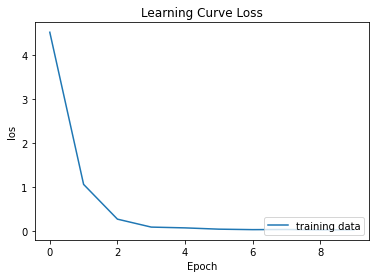

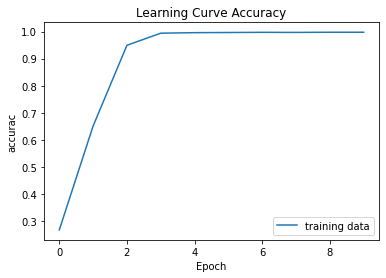

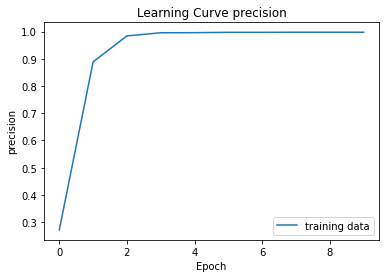

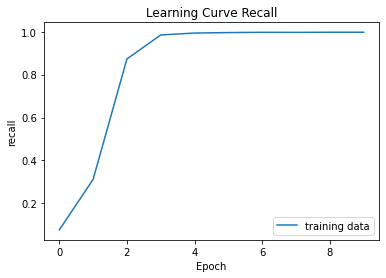

In [ ]:
test_overfitting(path0, [16],image_width, image_height)

Found 3176 images belonging to 5 classes.
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 252, 252, 16)      2320      
_________________________________________________________________
flatten_21 (Flatten)         (None, 1016064)           0         
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 5080325   
Total params: 5,083,093
Trainable params: 5,083,093
Non-trainable params: 0
_________________________________________________________________


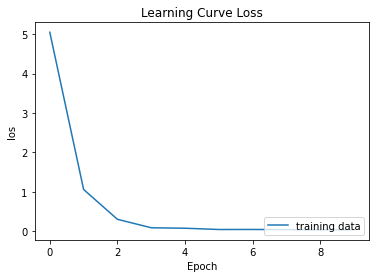

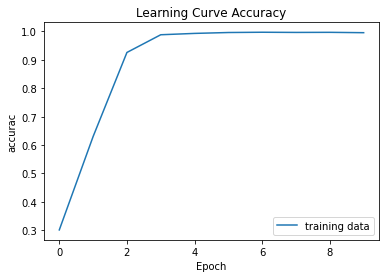

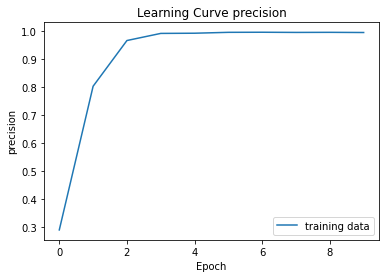

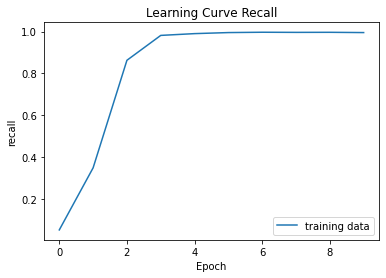

In [ ]:
test_overfitting(path0, [16,16],image_width, image_height)

Found 3176 images belonging to 5 classes.
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 252, 252, 16)      2320      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 250, 250, 16)      2320      
_________________________________________________________________
flatten_22 (Flatten)         (None, 1000000)           0         
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 5000005   
Total params: 5,005,093
Trainable params: 5,005,093
Non-trainable params: 0
_________________________________________________________________


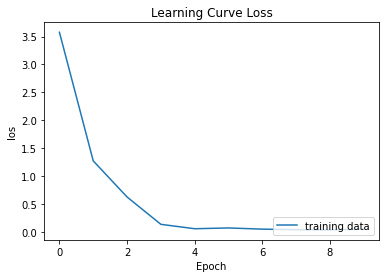

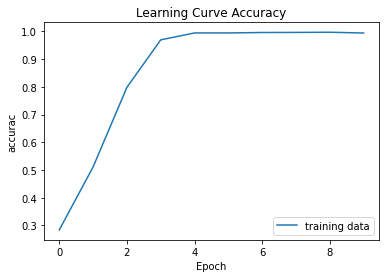

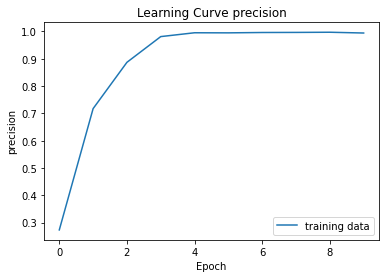

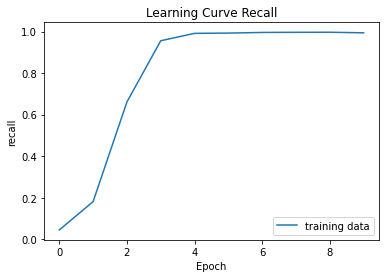

In [ ]:
test_overfitting(path0, [16,16,16],image_width, image_height)

Found 3176 images belonging to 5 classes.
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 252, 252, 16)      2320      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 250, 250, 16)      2320      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 248, 248, 16)      2320      
_________________________________________________________________
flatten_23 (Flatten)         (None, 984064)            0         
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 4920325   
Total params: 4,927,733
Trainable params: 4,927,733
Non-trainable params: 0
_

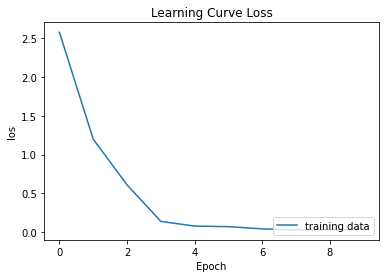

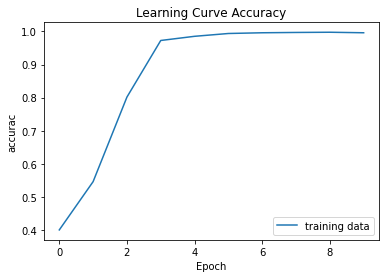

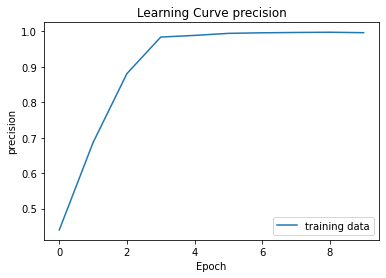

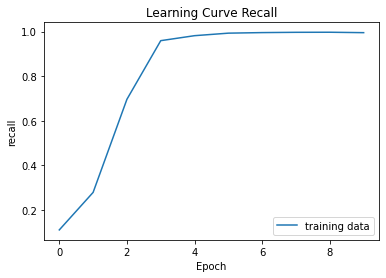

In [ ]:
test_overfitting(path0, [16,16,16,16],image_width, image_height)

Found 3176 images belonging to 5 classes.
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 252, 252, 16)      2320      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 250, 250, 16)      2320      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 248, 248, 16)      2320      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 246, 246, 16)      2320      
_________________________________________________________________
flatten_24 (Flatten)         (None, 968256)            0         
_________________________________________________________________
dense_40 (D

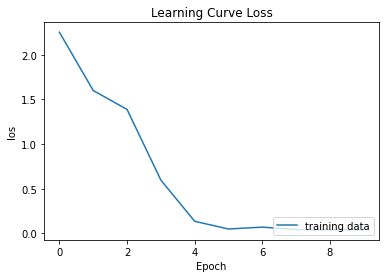

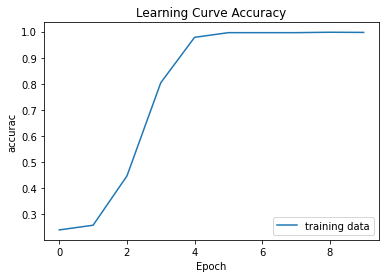

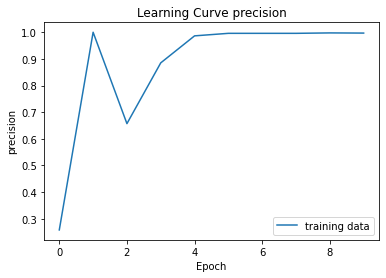

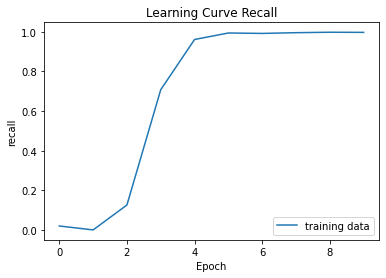

In [ ]:
test_overfitting(path0, [16,16,16,16,16],image_width, image_height)

Found 3176 images belonging to 5 classes.
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 252, 252, 16)      2320      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 250, 250, 16)      2320      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 248, 248, 16)      2320      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 246, 246, 16)      2320      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 244, 244, 16)      2320      
_________________________________________________________________
flatten_25 

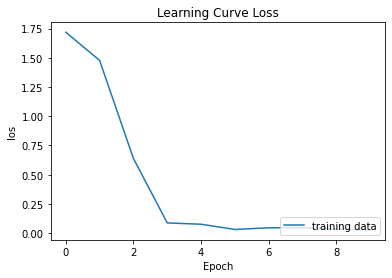

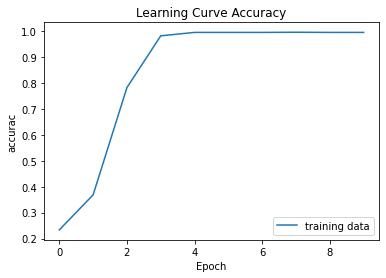

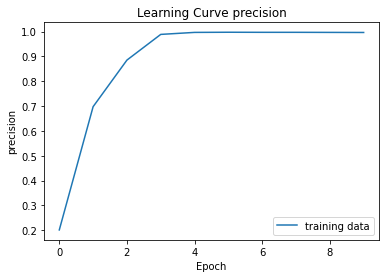

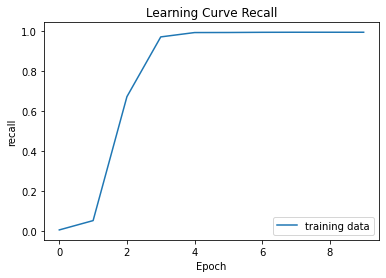

In [ ]:
test_overfitting(path0, [16,16,16,16,16,16],image_width, image_height)

From the structure above, you can add more layers

Found 3176 images belonging to 5 classes.
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
flatten_27 (Flatten)         (None, 2064512)           0         
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 10322565  
Total params: 10,323,461
Trainable params: 10,323,461
Non-trainable params: 0
_________________________________________________________________


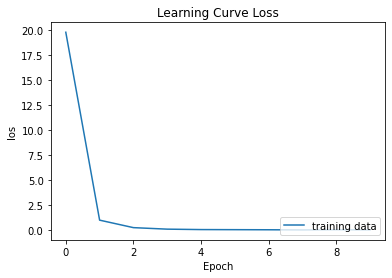

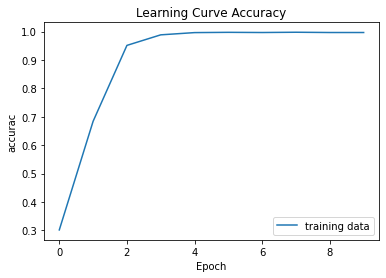

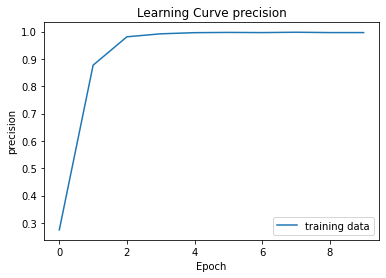

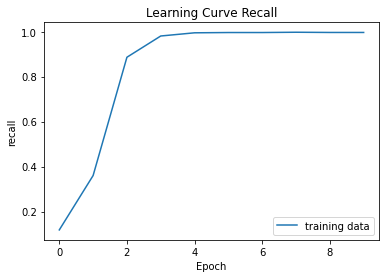

In [ ]:
test_overfitting(path0, [32],image_width, image_height)

Found 3176 images belonging to 5 classes.
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
flatten_28 (Flatten)         (None, 2032128)           0         
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 10160645  
Total params: 10,170,789
Trainable params: 10,170,789
Non-trainable params: 0
_________________________________________________________________


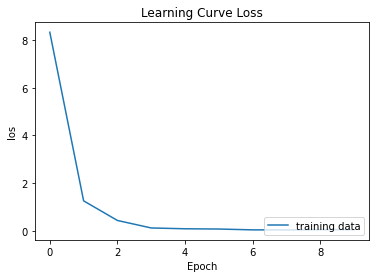

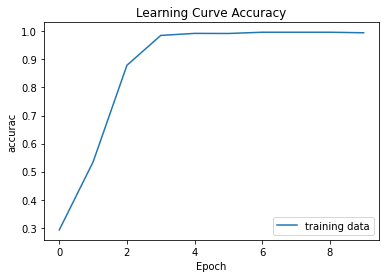

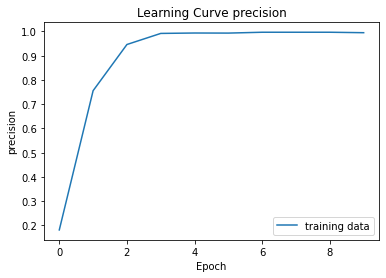

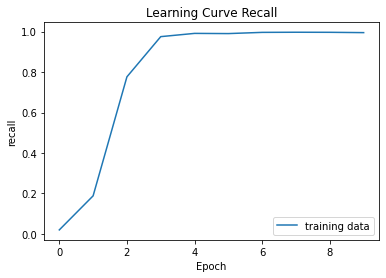

In [ ]:
test_overfitting(path0, [32,32],image_width, image_height)

Found 3176 images belonging to 5 classes.
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 252, 252, 32)      9248      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 250, 250, 32)      9248      
_________________________________________________________________
flatten_29 (Flatten)         (None, 2000000)           0         
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 10000005  
Total params: 10,019,397
Trainable params: 10,019,397
Non-trainable params: 0
_________________________________________________________________


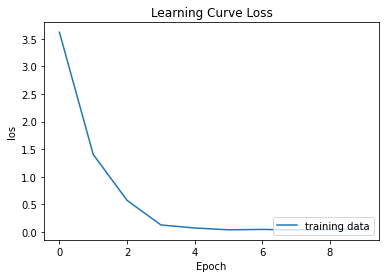

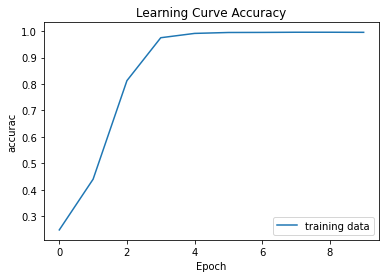

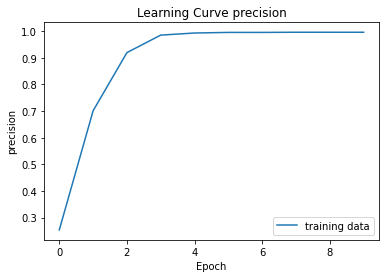

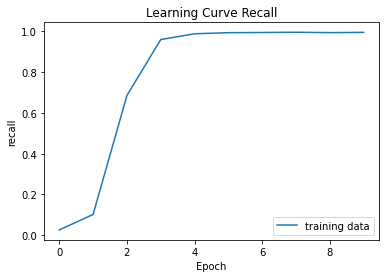

In [ ]:
test_overfitting(path0, [32,32,32],image_width, image_height)

Found 3176 images belonging to 5 classes.
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
flatten_30 (Flatten)         (None, 4129024)           0         
_________________________________________________________________
dense_46 (Dense)             (None, 5)                 20645125  
Total params: 20,646,917
Trainable params: 20,646,917
Non-trainable params: 0
_________________________________________________________________


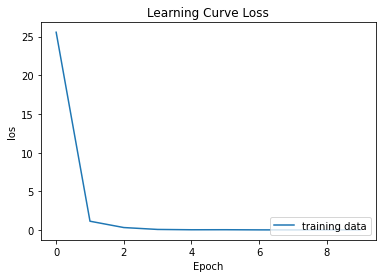

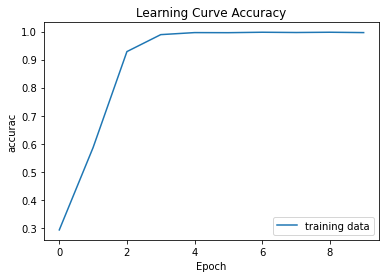

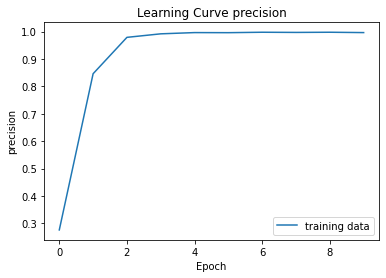

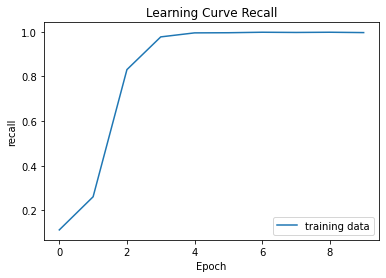

In [ ]:
test_overfitting(path0, [64],image_width, image_height)

Found 3176 images belonging to 5 classes.
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 252, 252, 64)      36928     
_________________________________________________________________
flatten_31 (Flatten)         (None, 4064256)           0         
_________________________________________________________________
dense_47 (Dense)             (None, 5)                 20321285  
Total params: 20,360,005
Trainable params: 20,360,005
Non-trainable params: 0
_________________________________________________________________


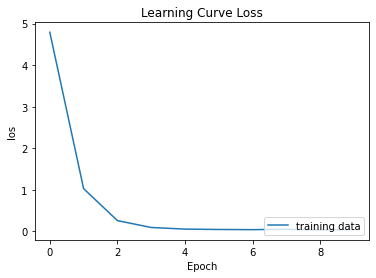

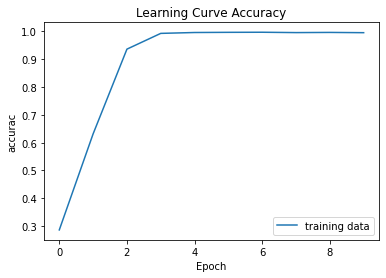

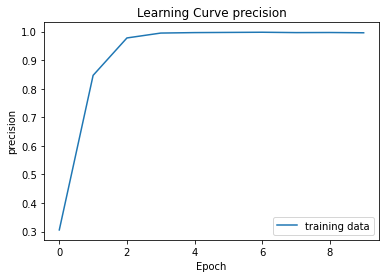

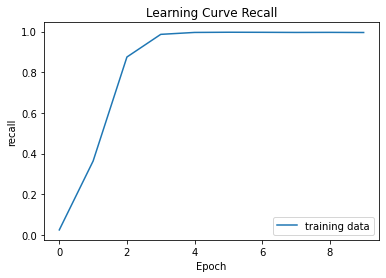

In [ ]:
test_overfitting(path0, [64,64],image_width, image_height)

Found 3176 images belonging to 5 classes.
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 252, 252, 64)      36928     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 250, 250, 64)      36928     
_________________________________________________________________
flatten_32 (Flatten)         (None, 4000000)           0         
_________________________________________________________________
dense_48 (Dense)             (None, 5)                 20000005  
Total params: 20,075,653
Trainable params: 20,075,653
Non-trainable params: 0
_________________________________________________________________


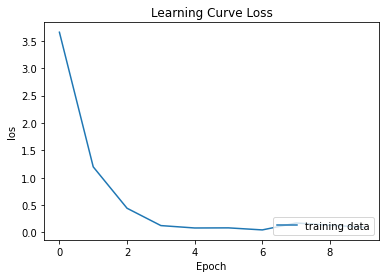

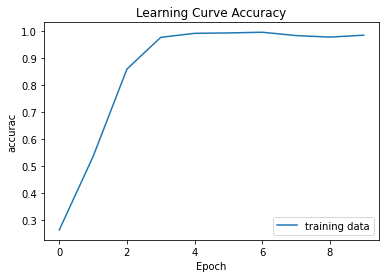

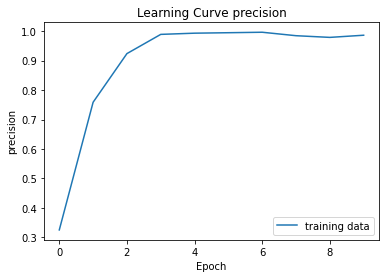

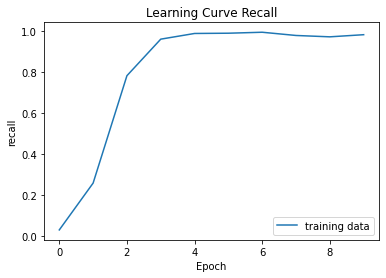

In [ ]:
test_overfitting(path0, [64,64,64],image_width, image_height)

From examples above, their accuracy reaches the almost 1, not matter which one to use.

1


## **#Phase III. Split and evaluate on test set**

In [ ]:
# this part is used to split images into training, valid and test datasets, it only show the result here since each
# time, random will generate different values
import random
files = os.listdir(path+'/train')
fileamount = []
for directoryName in files:
    # directories.append(directoryName)
    temp = path+'/train/'+directoryName
    fileamount.append(len(os.listdir(temp)))
print(fileamount)
print(sum(fileamount))
dirlist = ['cl','gr','gs','h','p']
for l in range(len(fileamount)):
    i = 0
    randNum = int(fileamount[l] * 0.3)
    print(randNum)
    fileIndex  = sorted(random.sample(range(fileamount[l]), randNum))
    print(fileIndex)
    f = open(str(dirlist[l]+".txt"), "w")
    for index in fileIndex:
        f.write(str(index)+"\n")
    f.close()

[550, 773, 614, 770, 469]
3176
165
[4, 6, 8, 11, 14, 18, 20, 22, 26, 28, 29, 31, 32, 33, 37, 38, 40, 41, 44, 46, 49, 52, 53, 55, 58, 60, 62, 64, 65, 68, 69, 77, 78, 79, 81, 84, 85, 87, 91, 92, 94, 99, 100, 101, 103, 104, 106, 112, 118, 119, 121, 123, 125, 127, 132, 139, 150, 152, 156, 159, 164, 168, 169, 176, 178, 184, 190, 196, 197, 202, 204, 211, 222, 229, 233, 234, 236, 241, 243, 250, 254, 256, 260, 263, 267, 271, 275, 278, 281, 285, 289, 290, 293, 301, 302, 303, 306, 312, 315, 316, 319, 321, 330, 333, 340, 341, 344, 349, 350, 352, 353, 363, 365, 370, 371, 376, 377, 378, 379, 385, 391, 393, 394, 395, 396, 397, 408, 410, 412, 415, 417, 418, 423, 425, 426, 430, 432, 433, 443, 446, 449, 454, 456, 457, 461, 463, 467, 473, 483, 488, 490, 491, 503, 505, 510, 517, 521, 523, 524, 529, 534, 535, 541, 547, 548]
231
[2, 6, 7, 9, 13, 15, 16, 19, 22, 25, 37, 38, 41, 44, 54, 57, 60, 63, 67, 68, 70, 77, 78, 84, 96, 98, 103, 105, 106, 108, 115, 117, 120, 121, 122, 123, 125, 127, 128, 130, 131, 133,

In [ ]:
i = 0
print(path)
print(len(validFiles))
dirlist = ['cl','gr','gs','h','p']
for dir in dirlist:
    print(validFiles[i])
    print(testFiles[i])
    for file in validFiles[i]:
        shutil.move(path+'/train/'+dir+'/'+file, path+'/valid/'+dir+'/'+file)
    for file in testFiles[i]:
        shutil.move(path+'/train/'+dir+'/'+file, path+'/test/'+dir+'/'+file)
    
    i = i + 1
# by now, the files have been split into train, valid and test  

/content/drive/My Drive/DL/DOG
5
['image (2).jpeg', 'image.jpeg', 'image (17).jpeg', 'images (32).jpeg', 'images (4).jpeg', 'images (54).jpeg', 'images (55).jpeg', 'images (40).jpeg', 'images (12).jpeg', 'images (38).jpeg', 'image (19).jpeg', 'images (8).jpeg', 'images (13).jpeg', 'images (48).jpeg', 'images (22).jpeg', 'images (20).jpeg', 'images (3).jpeg', 'image (9).jpeg', 'images (15).jpeg', 'image (16).jpeg', 'image (10).jpeg', 'images (41).jpeg', 'images (19).jpeg', 'images (50).jpeg', 'image (14).jpeg', 'image (4).jpeg', 'images (46).jpeg', 'image (18).jpeg', 'images (16).jpeg', 'image (1).jpeg', 'images (5).jpeg', 'images (503).jpeg', 'images (123).jpeg', 'images (338).jpeg', 'images (354).jpeg', 'images (165).jpeg', 'images (300).jpeg', 'images (68).jpeg', 'images (138).jpeg', 'images (162).jpeg', 'images (112).jpeg', 'images (228).jpeg', 'images (113).jpeg', 'images (109).jpeg', 'images (84).jpeg', 'images (318).jpeg', 'images (455).jpeg', 'images (124).jpeg', 'images (227).j

In [ ]:
# get train, valid and test generators
def get_all_generators(path, image_width, image_height):
    my_generator = ImageDataGenerator(rescale=1./255)
    train_generator = my_generator.flow_from_directory( path+'/train/', target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
    valid_generator = my_generator.flow_from_directory( path+'/valid/', target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
    test_generator = my_generator.flow_from_directory( path+'/test/', target_size=(image_width, image_height), batch_size=32, class_mode='categorical')

    return train_generator, valid_generator, test_generator

# overfitting the model with early stop
def overfitting_early_stop(train_generator, valid_generator, test_generator, layers,image_width, image_height):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, mode='max')
    model = Sequential()
    j = 0
    for i in range(len(layers)):
        if i == 0:
            model.add( Conv2D( layers[i], ( 3, 3 ), activation = 'relu' , input_shape = (image_width, image_height, 3)))
        else:
            model.add( Conv2D( layers[i], ( 3, 3 ), activation = 'relu'))
        i += 1
        model.add( MaxPool2D(2, 2) )
    model.add( Flatten() )
    model.add( Dense( 5, activation = 'softmax' ) )
    model.summary()
    model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall() ] )
    history = model.fit( train_generator, validation_data = valid_generator, epochs = 30, batch_size = 64, callbacks=[early_stopping])
    score = model.evaluate_generator(test_generator, verbose=0)
    print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    return history

# plot the learning curve, for accuracy, loss, precision, and recall 
def plot_learning_curve(history, key1, key2, ylabel, title):
    plt.plot(history.history[key1])
    plt.plot(history.history[key2])
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(['training data', 'validation data'], loc='lower right')
    plt.title(title)
    plt.show()

# test the result
def test_early_stop(path, layers,image_width, image_height):
    train_generator, valid_generator, test_generator = get_all_generators(path, image_width, image_height)
    history = overfitting_early_stop(train_generator, valid_generator, test_generator, layers,image_width, image_height)
    plot_learning_curve(history, list(history.history.keys())[0],list(history.history.keys())[4], 
                        list(history.history.keys())[0], 'Learning Curve Loss')
    plot_learning_curve(history, list(history.history.keys())[1],list(history.history.keys())[5], 
                        list(history.history.keys())[1], 'Learning Curve Accuracy')
    plot_learning_curve(history, list(history.history.keys())[2],list(history.history.keys())[6], 
                        list(history.history.keys())[2][:list(history.history.keys())[2].rfind('_')], 'Learning Curve Precision')
    plot_learning_curve(history, list(history.history.keys())[3],list(history.history.keys())[7], 
                        list(history.history.keys())[3][:list(history.history.keys())[3].rfind('_')], 'Learning Curve Recall')
    return history





Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 516128)            0         
_________________________________________________________________
dense_70 (Dense)             (None, 5)                 2580645   
Total params: 2,581,541
Trainable params: 2,581,541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
70/70 [==============================] - 16s 225ms/step - loss: 10.0567 - accuracy: 0.2638 - precision_38:

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.034569025039673 / Test accuracy: 0.5069444179534912


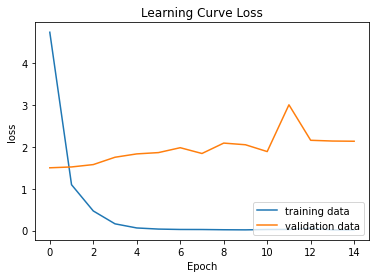

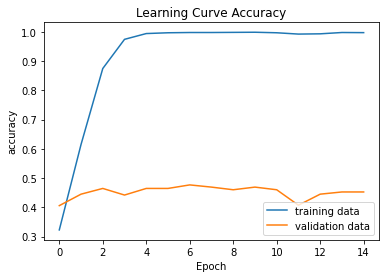

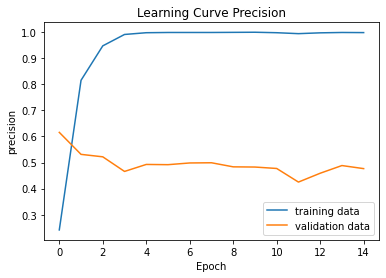

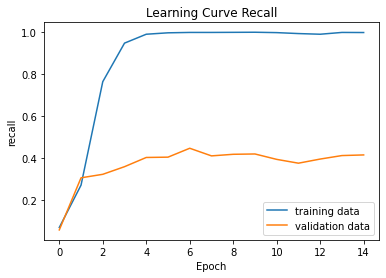

In [ ]:
history = test_early_stop(path, [32],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_71 (Dense)             (None, 5)                 615045

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.853086233139038 / Test accuracy: 0.4756944477558136


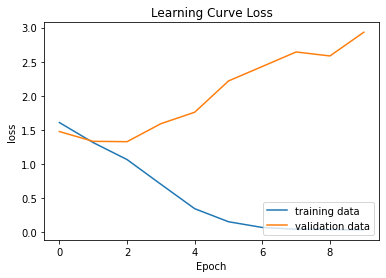

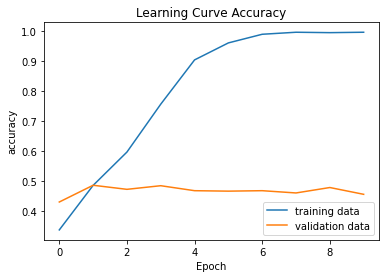

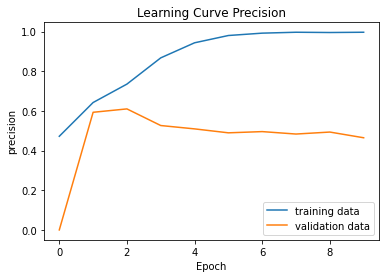

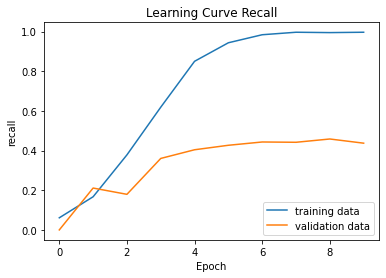

In [ ]:
history = test_early_stop(path, [32,32],image_width, image_height)


Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 30, 30, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 3.1409497261047363 / Test accuracy: 0.5104166865348816


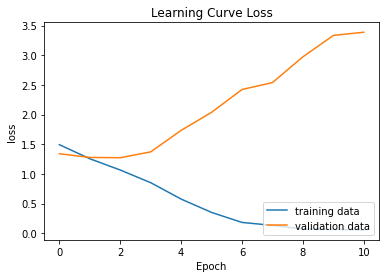

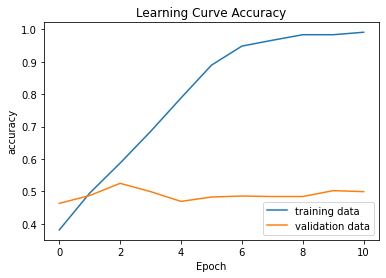

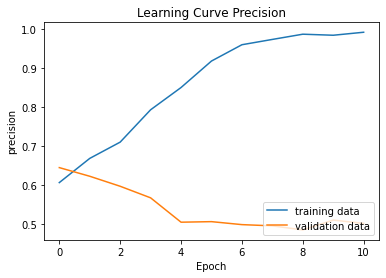

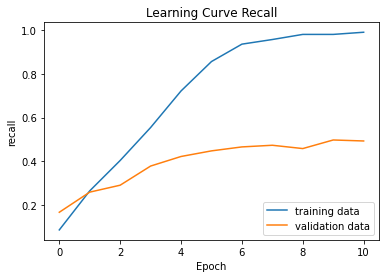

In [ ]:
history = test_early_stop(path, [32,32,32],image_width, image_height)


Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 30, 30, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.281705141067505 / Test accuracy: 0.5486111044883728


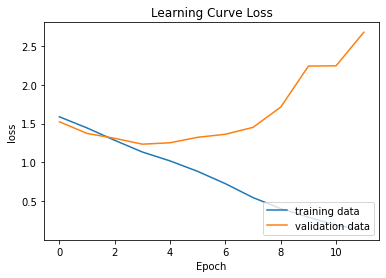

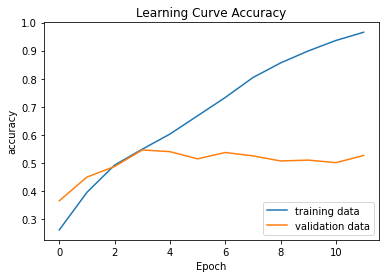

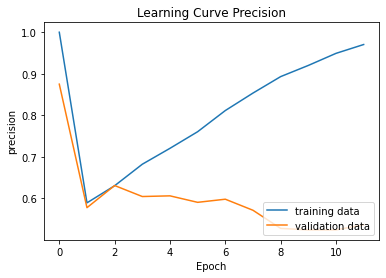

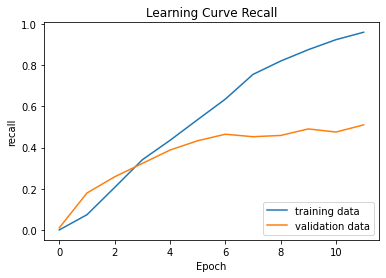

In [ ]:
history = test_early_stop(path, [32,32,32,32],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 30, 30, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.6675474643707275 / Test accuracy: 0.5729166865348816


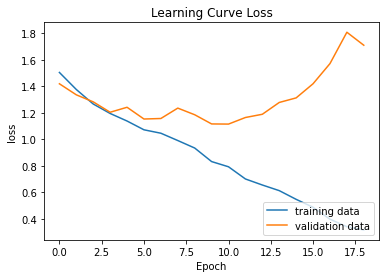

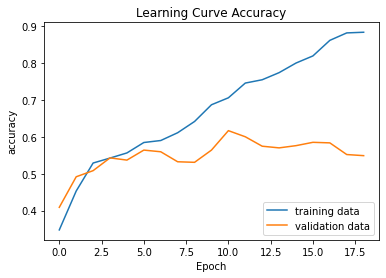

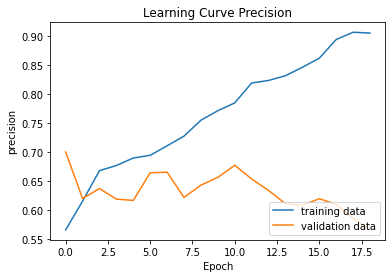

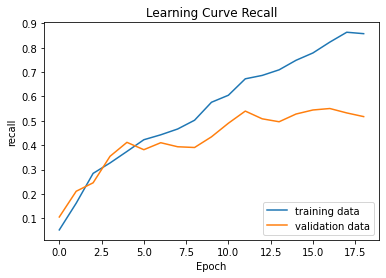

In [ ]:
history = test_early_stop(path, [32,32,32,32,32],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 30, 30, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.61752188205719 / Test accuracy: 0.6076388955116272


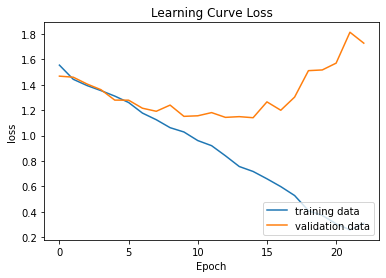

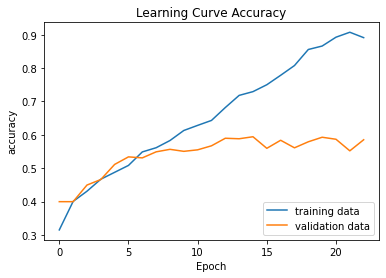

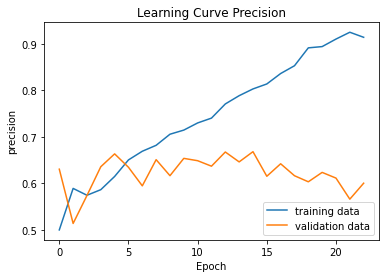

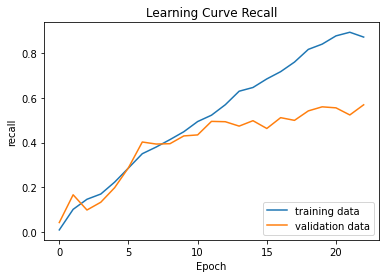

In [ ]:
history = test_early_stop(path, [32,32,32,32,32,32],image_width, image_height)

In [ ]:
# history = test_early_stop(path, [32,32,32,32,32,32,32],image_width, image_height)
# report error since too large system

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 258064)            0         
_________________________________________________________________
dense_49 (Dense)             (None, 5)                 1290325   
Total params: 1,290,773
Trainable params: 1,290,773
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
70/70 [==============================] - 549s 8s/step - loss: 14.2754 - accuracy: 0.2504 - precision_33: 0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.035675287246704 / Test accuracy: 0.5208333134651184


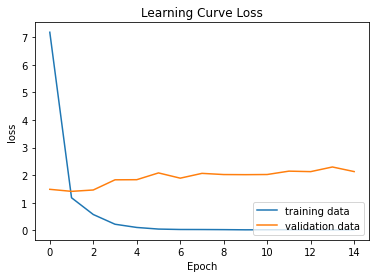

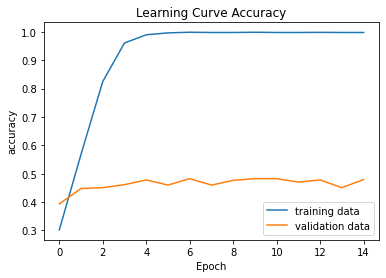

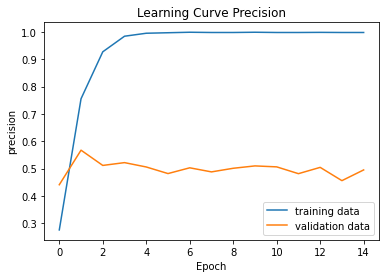

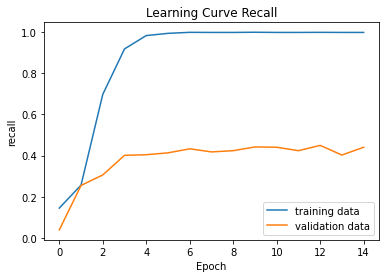

In [ ]:
history = test_early_stop(path, [16],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 61504)             0         
_________________________________________________________________
dense_77 (Dense)             (None, 5)                 307525

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.2802600860595703 / Test accuracy: 0.4895833432674408


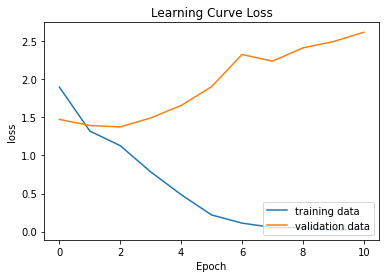

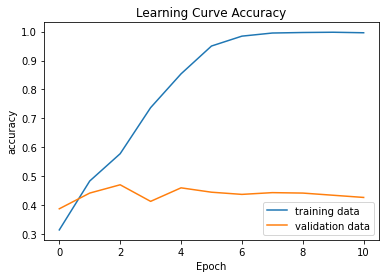

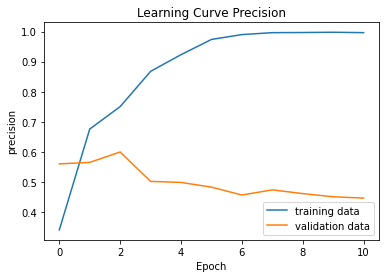

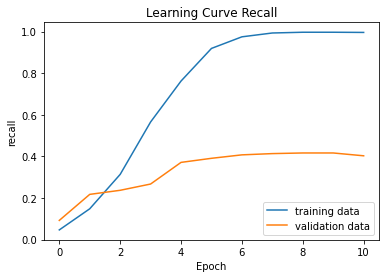

In [ ]:
history = test_early_stop(path, [16,16],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_127 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 30, 30, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 3.018557548522949 / Test accuracy: 0.5


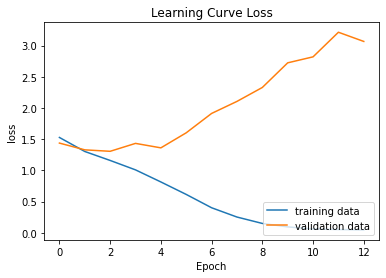

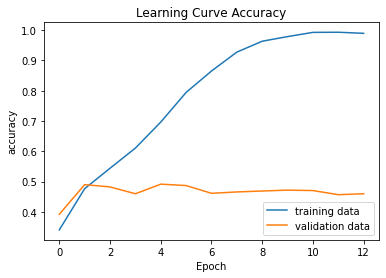

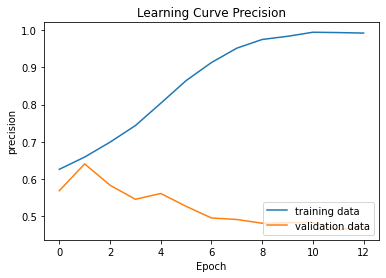

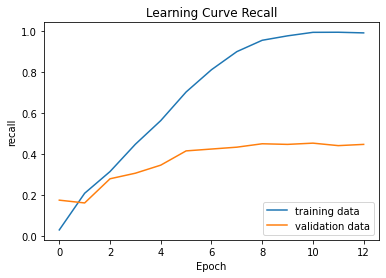

In [ ]:
history = test_early_stop(path, [16,16,16],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_130 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 30, 30, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.747133493423462 / Test accuracy: 0.5486111044883728


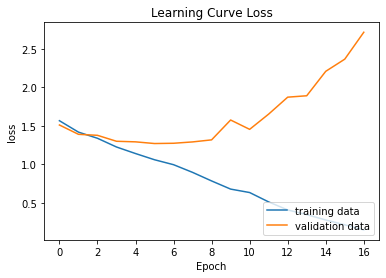

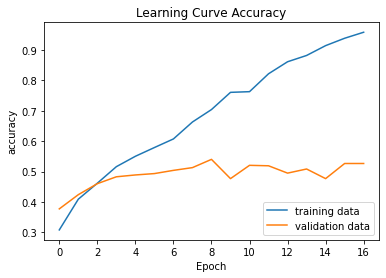

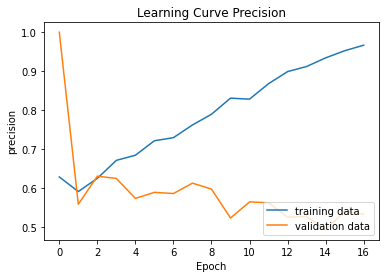

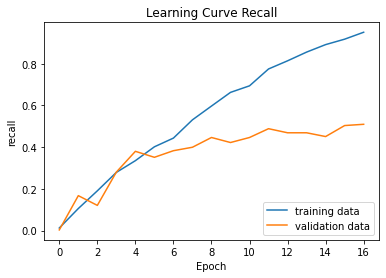

In [ ]:
history = test_early_stop(path, [16,16,16,16],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_134 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_119 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 30, 30, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.5836231708526611 / Test accuracy: 0.5694444179534912


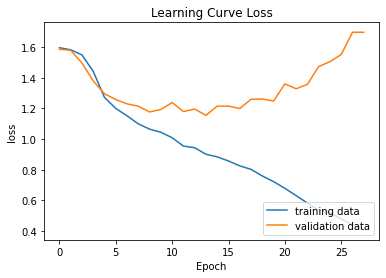

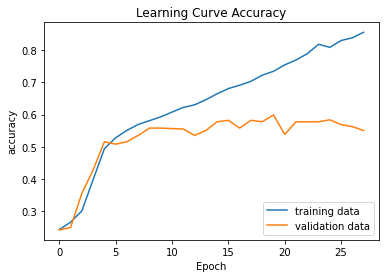

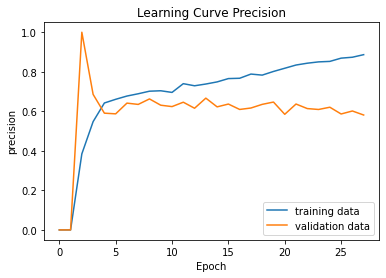

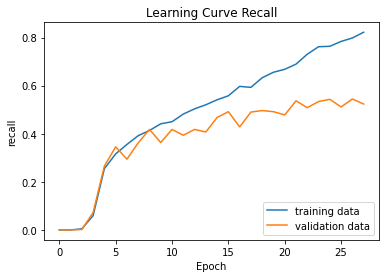

In [ ]:
history = test_early_stop(path, [16,16,16,16,16],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_139 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_124 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 30, 30, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.1179097890853882 / Test accuracy: 0.6284722089767456


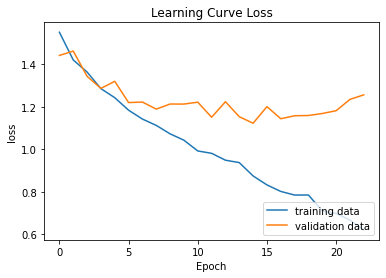

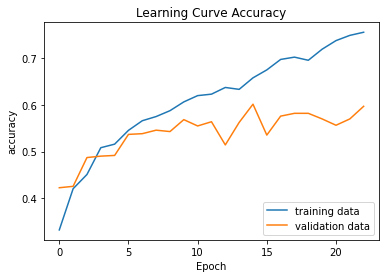

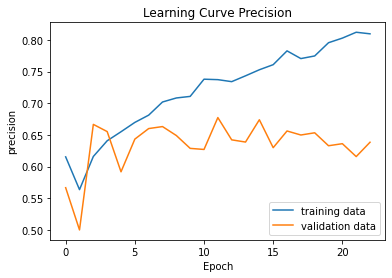

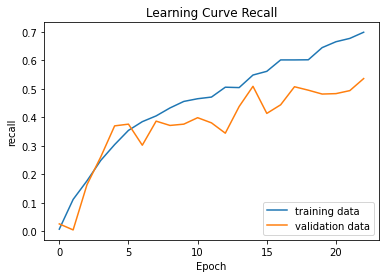

In [ ]:
history = test_early_stop(path, [16,16,16,16,16,16],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 1032256)           0         
_________________________________________________________________
dense_50 (Dense)             (None, 5)                 5161285   
Total params: 5,163,077
Trainable params: 5,163,077
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
70/70 [==============================] - 13s 180ms/step - loss: 13.8639 - accuracy: 0.2561 - precision_34:

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.1021664142608643 / Test accuracy: 0.5277777910232544


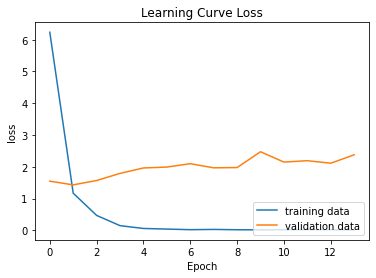

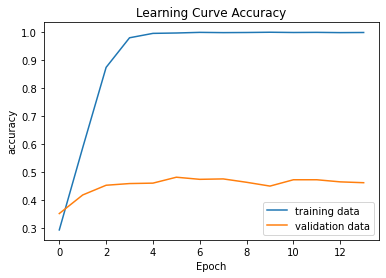

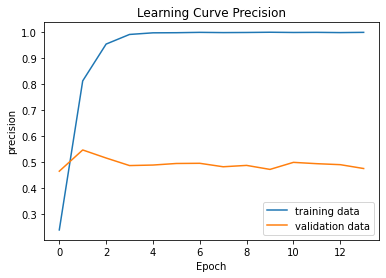

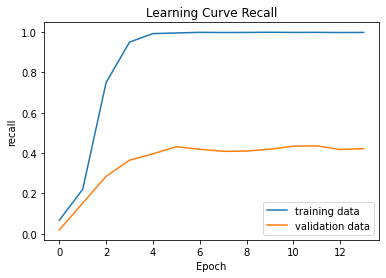

In [ ]:
history = test_early_stop(path, [64],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 246016)            0         
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 123008

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.93526029586792 / Test accuracy: 0.4930555522441864


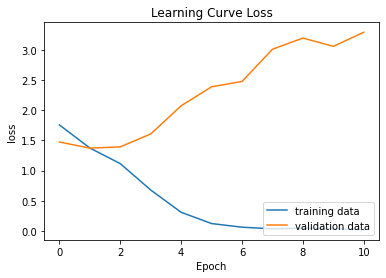

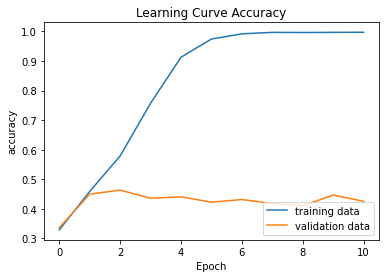

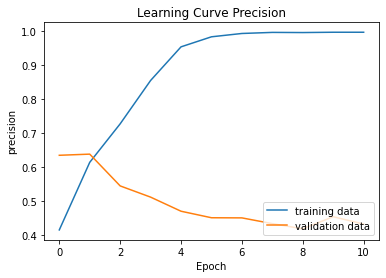

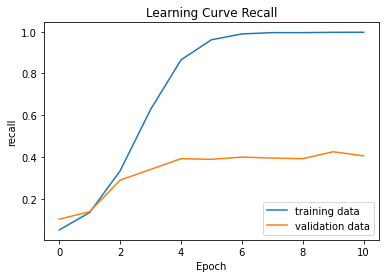

In [ ]:
history = test_early_stop(path, [64,64],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 30, 30, 64)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 3.255632162094116 / Test accuracy: 0.5208333134651184


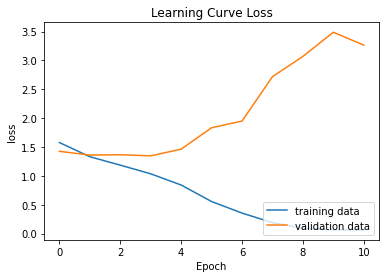

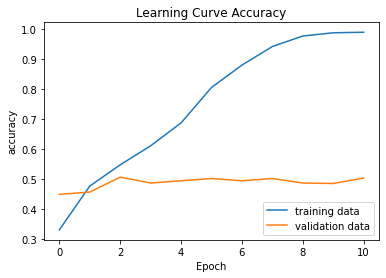

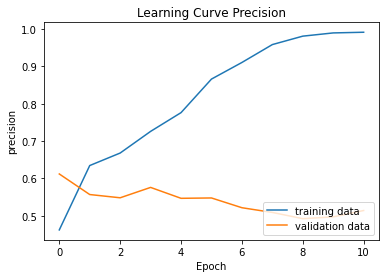

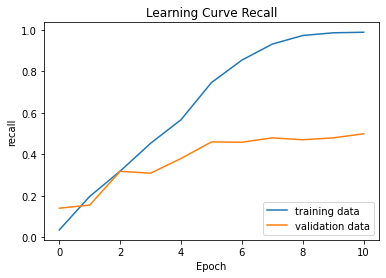

In [ ]:
history = test_early_stop(path, [64,64,64],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 30, 30, 64)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 3.244446039199829 / Test accuracy: 0.5763888955116272


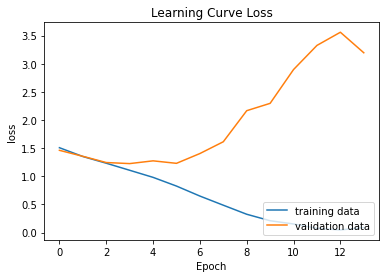

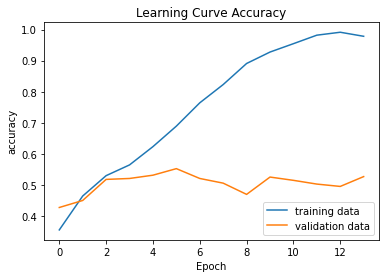

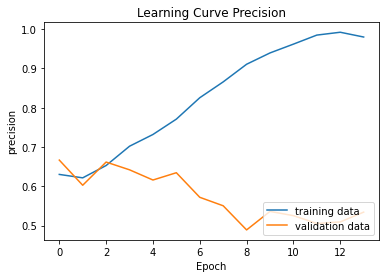

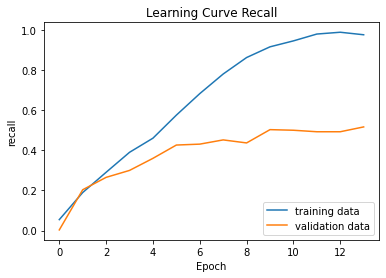

In [ ]:
history = test_early_stop(path, [64,64,64,64],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 30, 30, 64)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.828472852706909 / Test accuracy: 0.6041666865348816


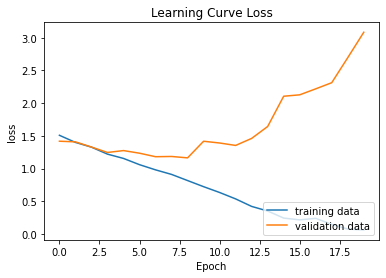

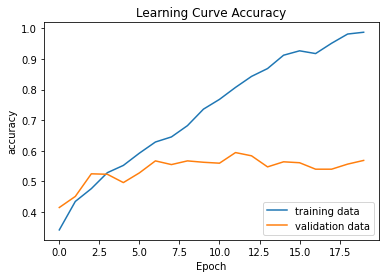

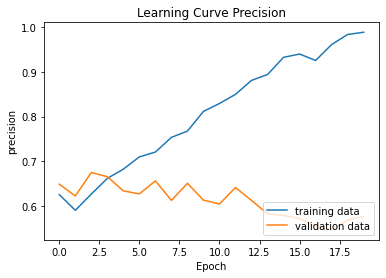

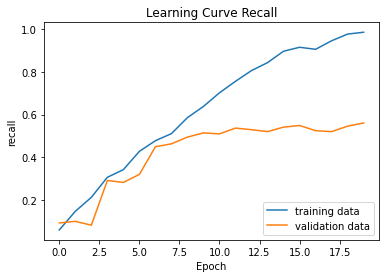

In [ ]:
history = test_early_stop(path, [64,64,64,64,64],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 30, 30, 64)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.9466347694396973 / Test accuracy: 0.6180555820465088


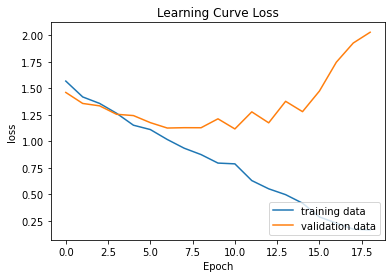

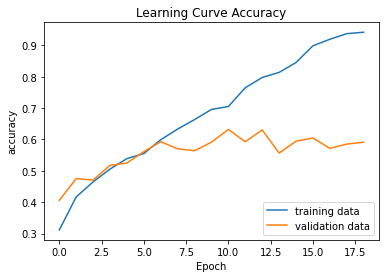

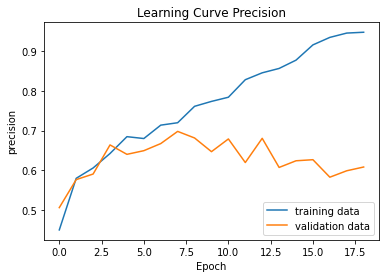

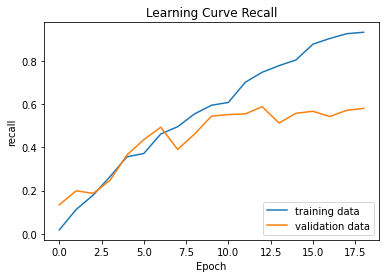

In [ ]:
history = test_early_stop(path, [64,64,64,64,64,64],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 127, 127, 128)     0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 2064512)           0         
_________________________________________________________________
dense_56 (Dense)             (None, 5)                 10322565  
Total params: 10,326,149
Trainable params: 10,326,149
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
70/70 [==============================] - 14s 182ms/step - loss: 31.0026 - accuracy: 0.2252 - precision_4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.1481478214263916 / Test accuracy: 0.46875


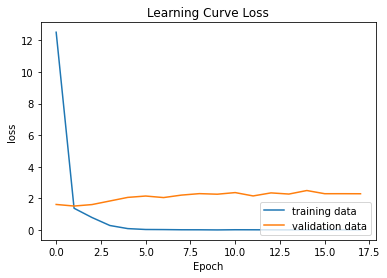

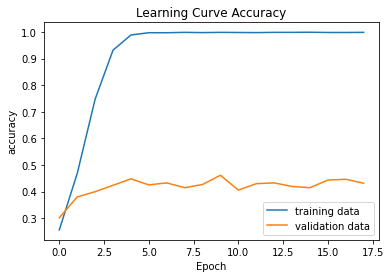

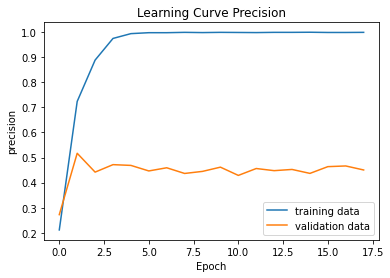

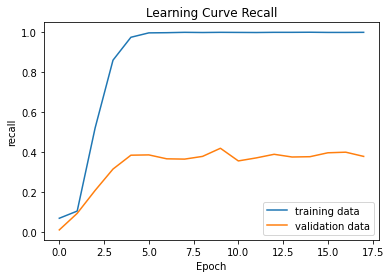

In [ ]:
history = test_early_stop(path, [128],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 125, 125, 128)     147584    
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 492032)            0         
_________________________________________________________________
dense_57 (Dense)             (None, 5)                 246016

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 3.780939817428589 / Test accuracy: 0.4548611044883728


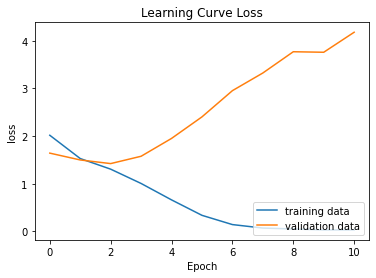

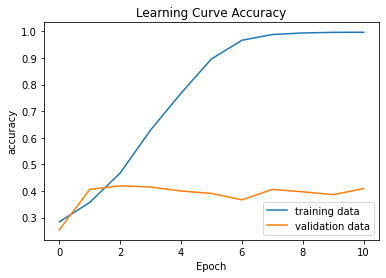

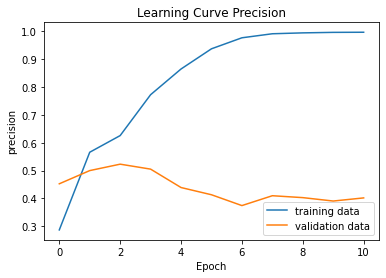

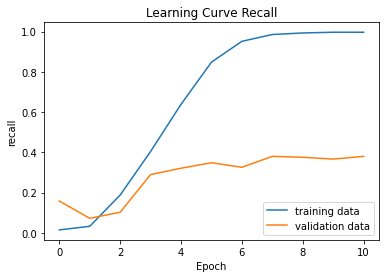

In [ ]:
history = test_early_stop(path, [128,128],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 125, 125, 128)     147584    
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 60, 60, 128)       147584    
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 30, 30, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 3.2592039108276367 / Test accuracy: 0.4895833432674408


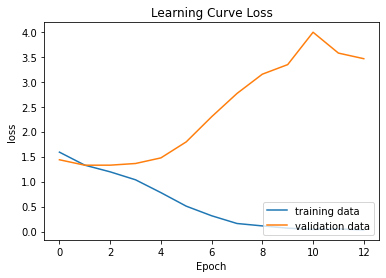

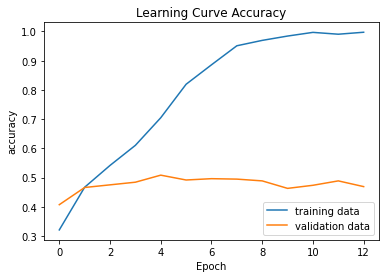

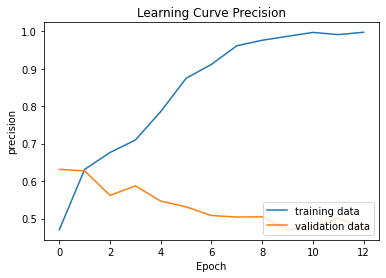

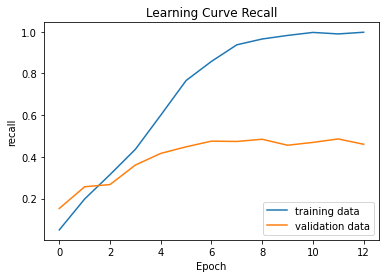

In [ ]:
history = test_early_stop(path, [128,128,128],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 125, 125, 128)     147584    
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 60, 60, 128)       147584    
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 30, 30, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 3.0386593341827393 / Test accuracy: 0.5555555820465088


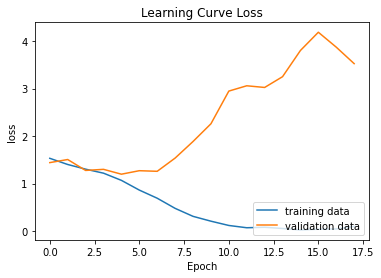

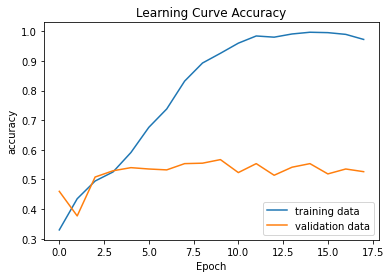

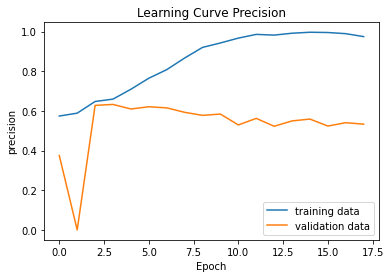

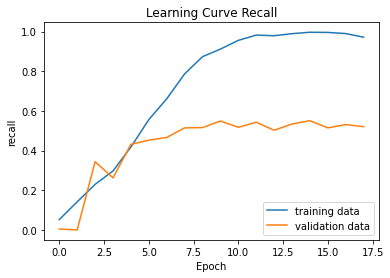

In [ ]:
history = test_early_stop(path, [128,128,128,128],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 125, 125, 128)     147584    
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 60, 60, 128)       147584    
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 30, 30, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 3.0249531269073486 / Test accuracy: 0.6076388955116272


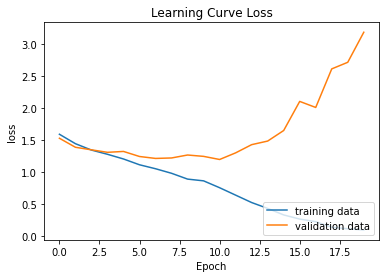

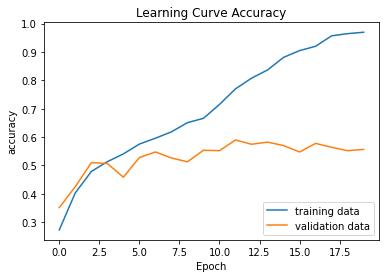

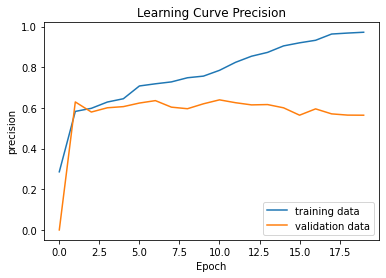

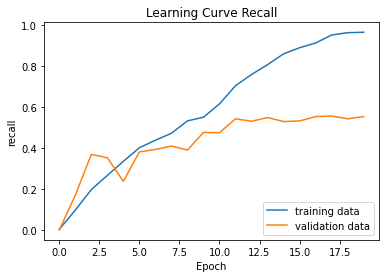

In [ ]:
history = test_early_stop(path, [128,128,128,128,128],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 125, 125, 128)     147584    
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 60, 60, 128)       147584    
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 30, 30, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.0992560386657715 / Test accuracy: 0.6354166865348816


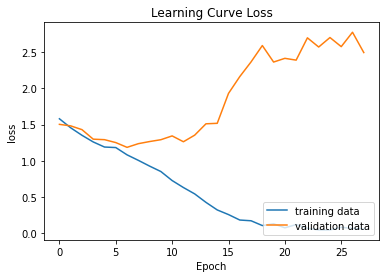

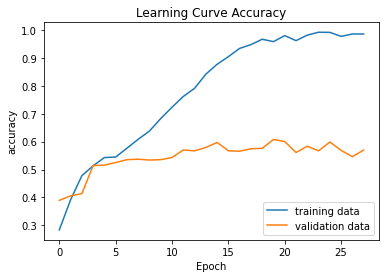

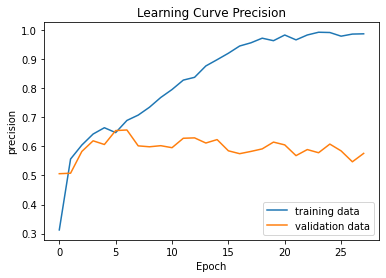

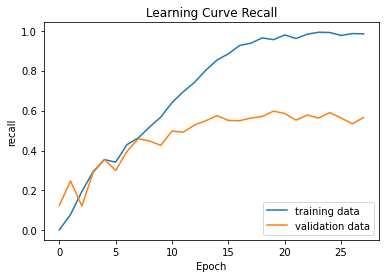

In [ ]:
history = test_early_stop(path, [128,128,128,128,128,128],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 254, 254, 256)     7168      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 127, 127, 256)     0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 4129024)           0         
_________________________________________________________________
dense_63 (Dense)             (None, 5)                 20645125  
Total params: 20,652,293
Trainable params: 20,652,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
70/70 [==============================] - 15s 196ms/step - loss: 24.3211 - accuracy: 0.2343 - precision_4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.0706303119659424 / Test accuracy: 0.5069444179534912


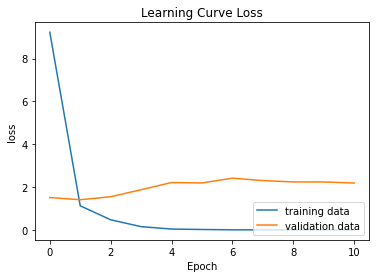

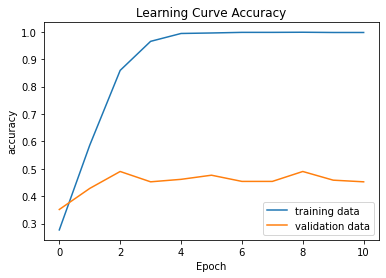

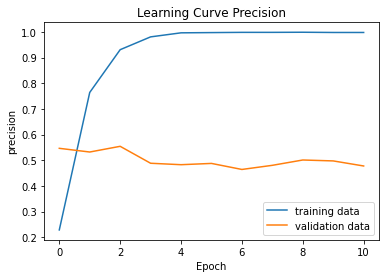

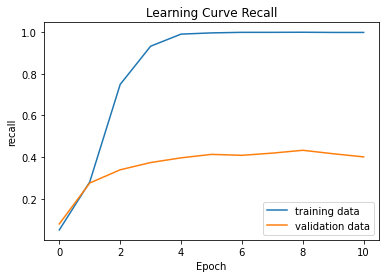

In [ ]:
history = test_early_stop(path, [256],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 254, 254, 256)     7168      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 125, 125, 256)     590080    
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 62, 62, 256)       0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 984064)            0         
_________________________________________________________________
dense_64 (Dense)             (None, 5)                 492032

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 6.4007391929626465 / Test accuracy: 0.3333333432674408


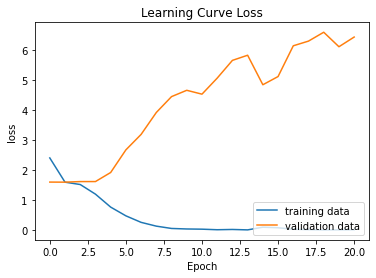

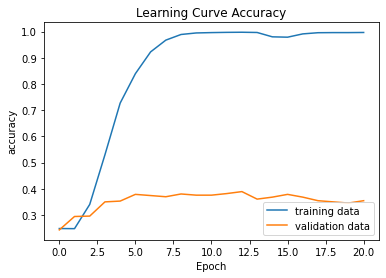

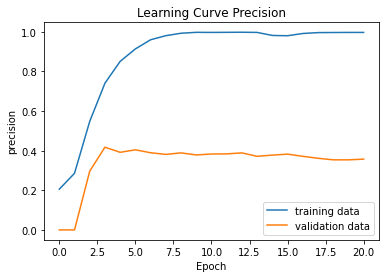

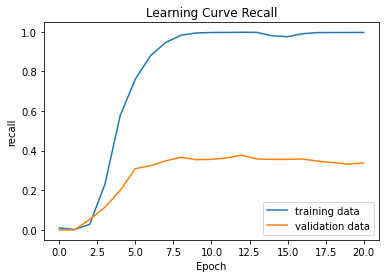

In [ ]:
history = test_early_stop(path, [256,256],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_113 (Conv2D)          (None, 254, 254, 256)     7168      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 125, 125, 256)     590080    
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 60, 60, 256)       590080    
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 30, 30, 256)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 3.770984172821045 / Test accuracy: 0.4826388955116272


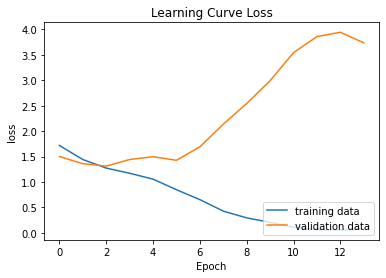

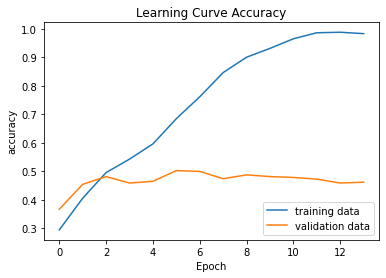

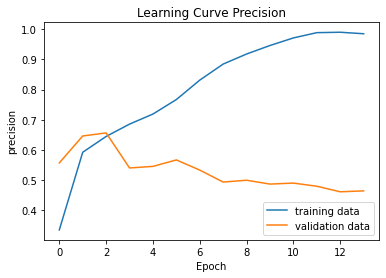

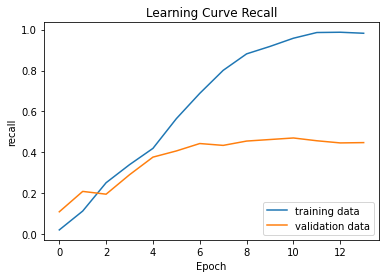

In [ ]:
history = test_early_stop(path, [256,256,256],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 254, 254, 256)     7168      
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 125, 125, 256)     590080    
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 60, 60, 256)       590080    
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 30, 30, 256)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 3.168809175491333 / Test accuracy: 0.5729166865348816


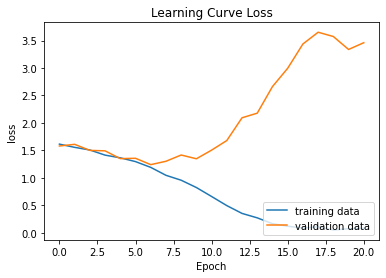

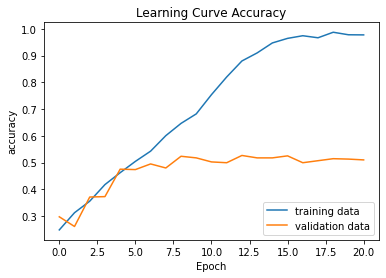

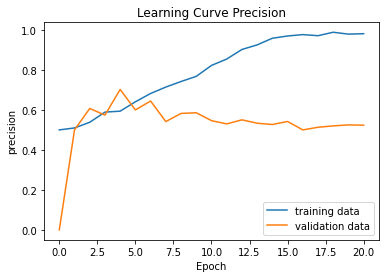

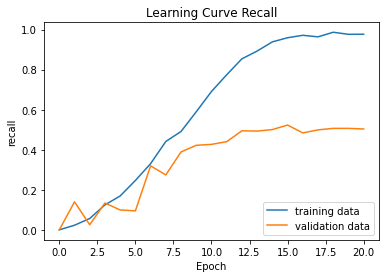

In [ ]:
history = test_early_stop(path, [256,256,256,256],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 254, 254, 256)     7168      
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 125, 125, 256)     590080    
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 60, 60, 256)       590080    
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 30, 30, 256)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 2.8513450622558594 / Test accuracy: 0.5902777910232544


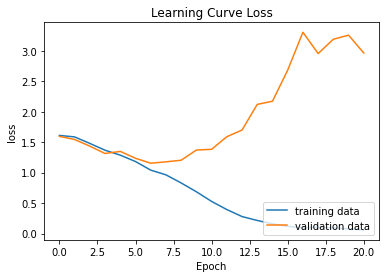

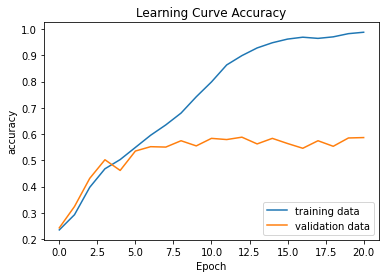

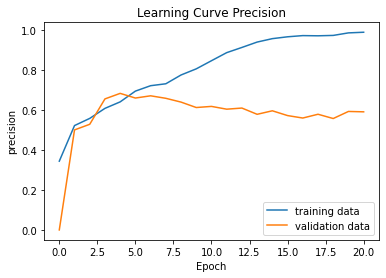

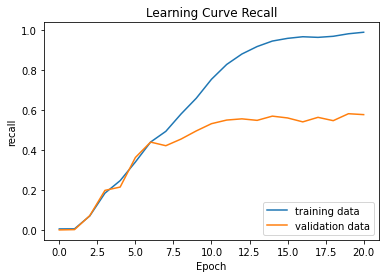

In [ ]:
history = test_early_stop(path, [256,256,256,256,256],image_width, image_height)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 254, 254, 256)     7168      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 125, 125, 256)     590080    
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 60, 60, 256)       590080    
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 30, 30, 256)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 3.7600936889648438 / Test accuracy: 0.5486111044883728


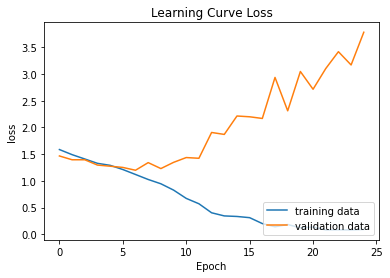

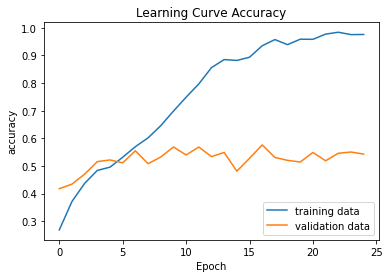

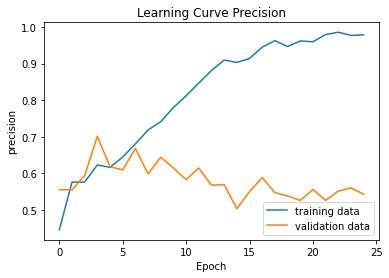

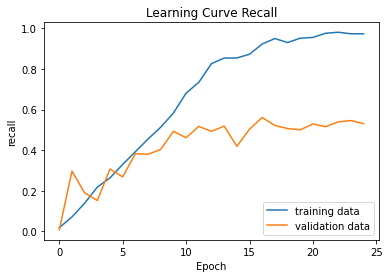

In [ ]:
history = test_early_stop(path, [256,256,256,256,256,256],image_width, image_height)

#Phase IV. Effects of augmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# use augmentation to process it

from tensorflow.keras.preprocessing.image import ImageDataGenerator    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
import time
path = '/content/drive/My Drive/DL/DOG' 

def get_generator(path = path, rotation = 45, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest'):
    my_generator = ImageDataGenerator(rotation_range=rotation,
        width_shift_range=width,
        height_shift_range=height,
        shear_range=shear_range,
        zoom_range=zoom,
        horizontal_flip=flip,
        rescale=1./255,
        fill_mode=fill)
    train_generator = my_generator.flow_from_directory( path+'/train/', target_size=(150, 150), batch_size=4, class_mode='categorical')
    # Generator for validation dataset
    valid_generator = my_generator.flow_from_directory( path+'/valid/', target_size=(150, 150), batch_size=4, class_mode='categorical')
    test_generator = my_generator.flow_from_directory( path+'/test/', target_size=(150, 150), batch_size=4, class_mode='categorical')

    return train_generator, valid_generator, test_generator

# build, compile and fit model for generators, print evaluation score by test  andreturn hisotry value
def build_model(layers, train_generator,valid_generator, test_generator, epoch = 30, batch=64):
    model = Sequential()
    # did in Phase IV for more epoch values
    for i in range(layers):
        model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape = (150, 150, 3) ) ) # 0.2430555522441864
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add( Dense( 5, activation = 'softmax' ) )
    model.summary()

    model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, mode='max')


    start_time = time.time()
    history = model.fit(train_generator, validation_data = valid_generator, epochs = epoch, batch_size = batch, callbacks=[early_stopping], verbose=0)
    score = model.evaluate_generator( test_generator, verbose=0)
    print(f'Test Generator loss: {score[0]} / Test Generator accuracy: {score[1]}')

    print("--- Totally needs %s seconds ---" % (time.time() - start_time))
    return history

# to plot learning curve with y-axis of accuracy and x-axis of epoch
def accuracy_learning_curve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy Learning Curve')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['training data', 'validation data'], loc='lower left')
    plt.show()


# to plot learning curve with y-axis of loss and x-axis of epoch
def loss_learning_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss Learning Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training data', 'validation data'], loc='lower left')
    plt.show()


# start to test the result
def test_augmentation(rotation = 45, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest'):
    train_generator, valid_generator, test_generator = get_generator(path = path, rotation = 45, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest') 
    
    history = build_model(layers = 5, train_generator = train_generator,valid_generator = valid_generator, test_generator = test_generator)
    accuracy_learning_curve(history)
    loss_learning_curve(history)
    





    






Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 36, 36, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.1535940170288086 / Test Generator accuracy: 0.5729166865348816
--- Totally needs 1094.2086560726166 seconds ---


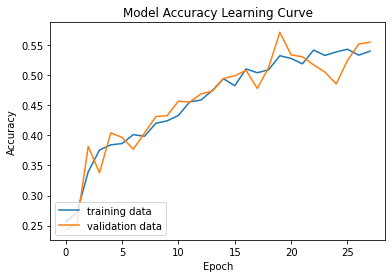

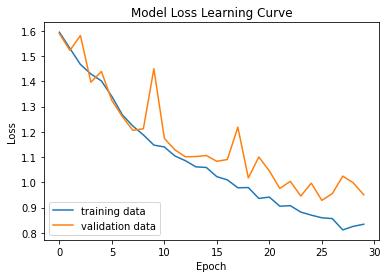

In [ ]:
# for augmentation case 1
test_augmentation(rotation = 45, shear_range = 0.2)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 36, 36, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.1310985088348389 / Test Generator accuracy: 0.5694444179534912
--- Totally needs 1088.5836255550385 seconds ---


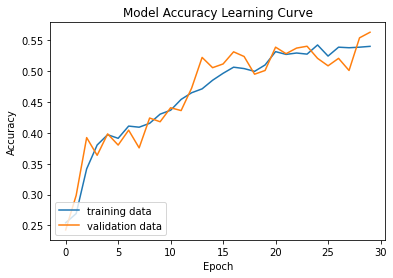

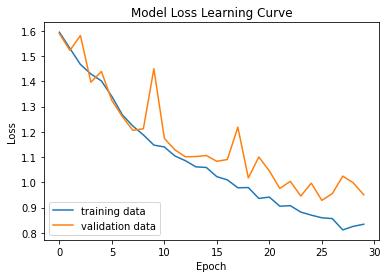

In [ ]:
# for augmentation case 2
test_augmentation(rotation = 90, shear_range = 0.2)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 36, 36, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.1439259052276611 / Test Generator accuracy: 0.5694444179534912
--- Totally needs 1077.9010093212128 seconds ---


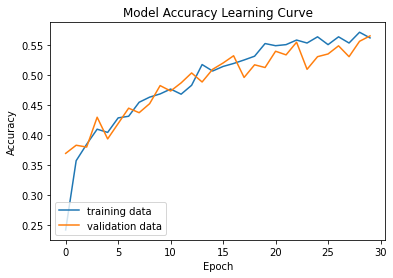

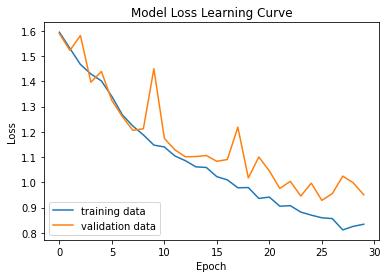

In [ ]:
# for augmentation case 3
test_augmentation(rotation = 135, shear_range = 0.2)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_86 (Dropout)         (None, 36, 36, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.1304365396499634 / Test Generator accuracy: 0.59375
--- Totally needs 1112.314823627472 seconds ---


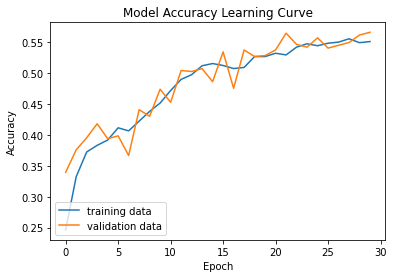

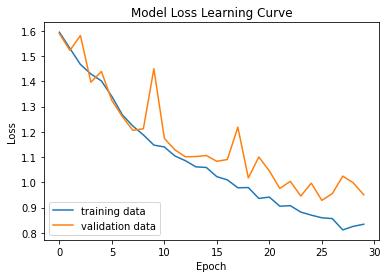

In [ ]:
# for augmentation case 4
test_augmentation(rotation = 180, shear_range = 0.2)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_90 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 36, 36, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.1394844055175781 / Test Generator accuracy: 0.5555555820465088
--- Totally needs 1148.8434081077576 seconds ---


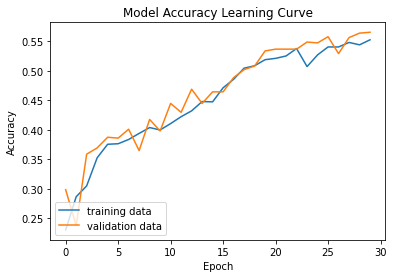

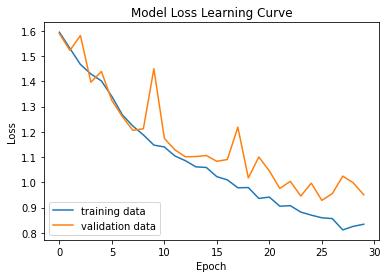

In [ ]:
# for augmentation case 5
test_augmentation(rotation = 45, zoom = 0.2)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_95 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 36, 36, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.2491837739944458 / Test Generator accuracy: 0.5347222089767456
--- Totally needs 1128.9613070487976 seconds ---


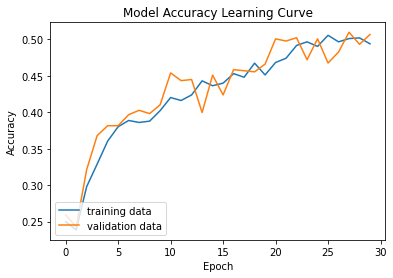

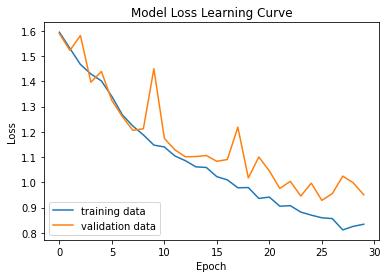

In [ ]:
# for augmentation case 6
test_augmentation(rotation = 45, zoom = 0.4)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_113 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 36, 36, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.1964040994644165 / Test Generator accuracy: 0.5833333134651184
--- Totally needs 1166.6663653850555 seconds ---


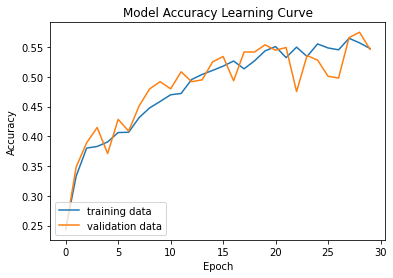

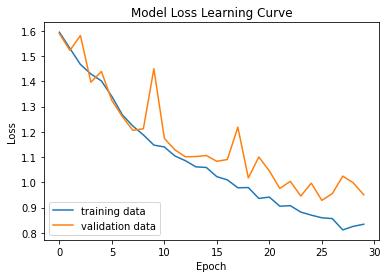

In [ ]:
# for augmentation case 7
test_augmentation(rotation = 45, zoom = 0.6)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_106 (Dropout)        (None, 36, 36, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.2360705137252808 / Test Generator accuracy: 0.5243055820465088
--- Totally needs 1177.9399206638336 seconds ---


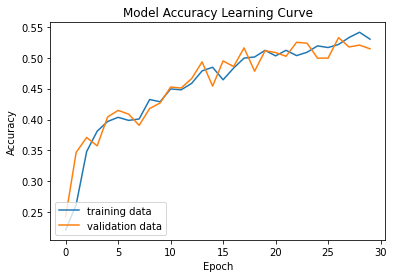

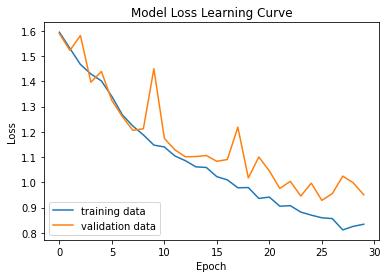

In [ ]:
# for augmentation case 8
test_augmentation(rotation = 45, zoom = 0.8)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 36, 36, 32)        0      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.175055742263794 / Test Generator accuracy: 0.5520833134651184
--- Totally needs 700.3496968746185 seconds ---


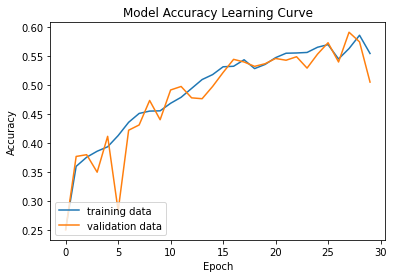

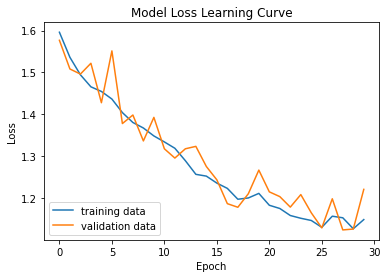

In [ ]:
# for augmentation case 9
test_augmentation( shear_range = 0.2)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 36, 36, 32)        0      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.2583613395690918 / Test Generator accuracy: 0.4895833432674408
--- Totally needs 703.169830083847 seconds ---


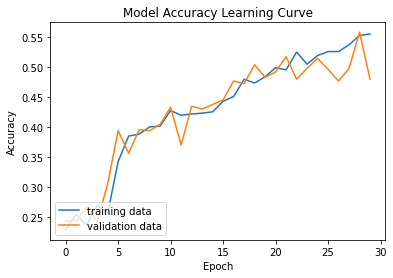

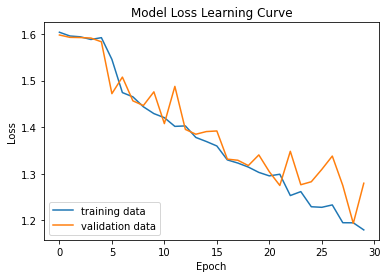

In [ ]:
# for augmentation case 10
test_augmentation( shear_range = 0.4)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 36, 36, 32)        0      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.125805377960205 / Test Generator accuracy: 0.5520833134651184
--- Totally needs 696.7958359718323 seconds ---


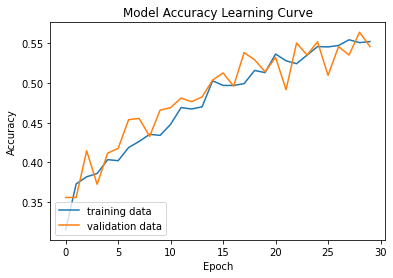

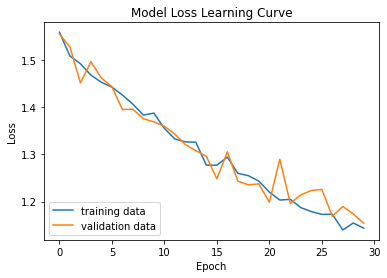

In [ ]:
# for augmentation case 11
test_augmentation( shear_range = 0.6)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 36, 36, 32)        0      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Generator loss: 1.1595263481140137 / Test Generator accuracy: 0.5763888955116272
--- Totally needs 696.7262210845947 seconds ---


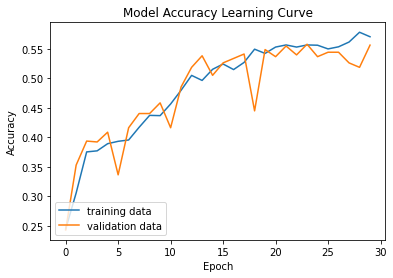

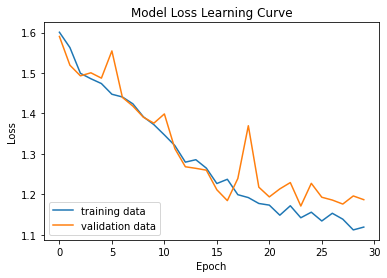

In [ ]:
# for augmentation case 12
test_augmentation( shear_range = 0.8)

#Phase IV. Effects of augmentation# get train, valid and test generators
Base the experiments above, I decide to use [16,16,16,16,16,16] as the optimal choice for the next step. 
In the experiments below, 3 types of parameters are tried:
rotation = [45,90,135,180]
zoom=[.2,.4,.6,.8]
shear=[.2,.4,.6,.8]

In [ ]:

def get_all_generators(path, image_width, image_height,rotation = 45, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest'):
    my_generator = ImageDataGenerator(rotation_range=rotation,width_shift_range=width,
        height_shift_range=height,shear_range=shear_range,
        zoom_range=zoom,horizontal_flip=flip,
        rescale=1./255,fill_mode=fill)
    train_generator = my_generator.flow_from_directory( path+'/train/', target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
    valid_generator = my_generator.flow_from_directory( path+'/valid/', target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
    test_generator = my_generator.flow_from_directory( path+'/test/', target_size=(image_width, image_height), batch_size=32, class_mode='categorical')

    return train_generator, valid_generator, test_generator

# overfitting the model with early stop
def overfitting_early_stop(train_generator, valid_generator, test_generator, layers,image_width, image_height, dropout):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, mode='max')
    model = Sequential()
    j = 0
    for i in range(len(layers)):
        if i == 0:
            model.add( Conv2D( layers[i], ( 3, 3 ), activation = 'relu' , input_shape = (image_width, image_height, 3)))
        else:
            model.add( Conv2D( layers[i], ( 3, 3 ), activation = 'relu'))
        i += 1
        model.add( MaxPool2D(2, 2) )
        model.add(Dropout(dropout))
    model.add( Flatten() )
    model.add( Dense( 5, activation = 'softmax' ) )
    model.summary()
    model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall() ] )
    history = model.fit( train_generator, validation_data = valid_generator, epochs = 30, batch_size = 64, callbacks=[early_stopping])
    score = model.evaluate_generator(test_generator, verbose=0)
    print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    return history

# plot the learning curve, for accuracy, loss, precision, and recall 
def plot_learning_curve(history, key1, key2, ylabel, title):
    plt.plot(history.history[key1])
    plt.plot(history.history[key2])
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(['training data', 'validation data'], loc='lower right')
    plt.title(title)
    plt.show()

# test the result
def test_early_stop(path, layers,image_width, image_height, dropout=0.25, rotation = 45, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest'):
    train_generator, valid_generator, test_generator = get_all_generators(path, image_width, image_height,rotation = rotation, shear_range = shear_range, width = width, height = height, zoom = zoom, flip = True, fill = 'nearest')
    history = overfitting_early_stop(train_generator, valid_generator, test_generator, layers,image_width, image_height, dropout)
    plot_learning_curve(history, list(history.history.keys())[0],list(history.history.keys())[4], 
                        list(history.history.keys())[0], 'Learning Curve Loss')
    plot_learning_curve(history, list(history.history.keys())[1],list(history.history.keys())[5], 
                        list(history.history.keys())[1], 'Learning Curve Accuracy')
    plot_learning_curve(history, list(history.history.keys())[2],list(history.history.keys())[6], 
                        list(history.history.keys())[2][:list(history.history.keys())[2].rfind('_')], 'Learning Curve Precision')
    plot_learning_curve(history, list(history.history.keys())[3],list(history.history.keys())[7], 
                        list(history.history.keys())[3][:list(history.history.keys())[3].rfind('_')], 'Learning Curve Recall')
    return history






Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.3944703340530396 / Test accuracy: 0.46875


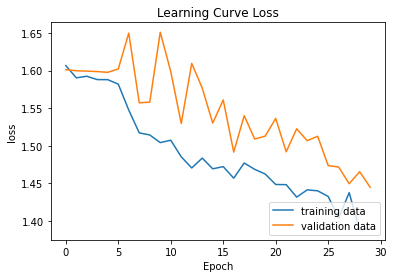

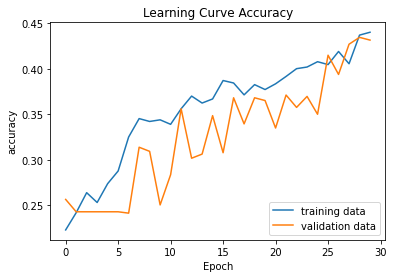

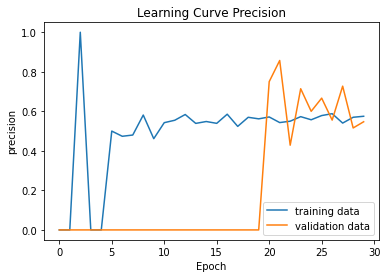

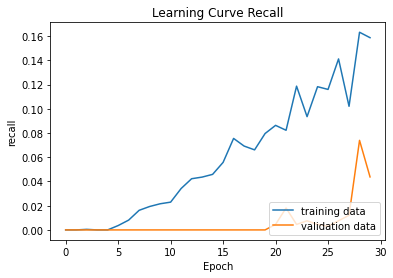

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 45, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest')


Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_137 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 62, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.2825002670288086 / Test accuracy: 0.5208333134651184


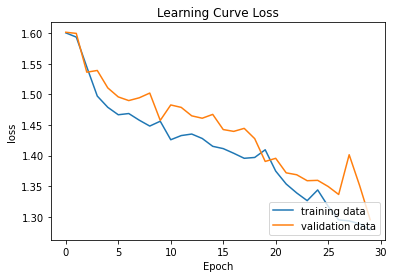

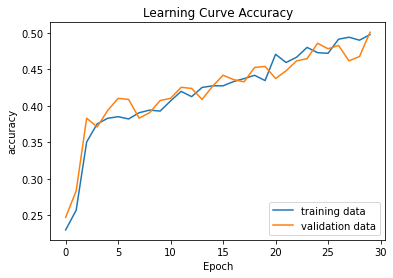

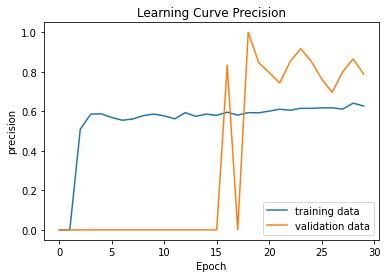

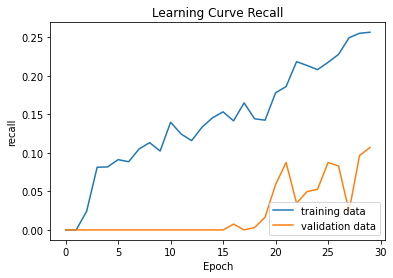

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 90, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest')


Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_143 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 62, 62, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.327869176864624 / Test accuracy: 0.4895833432674408


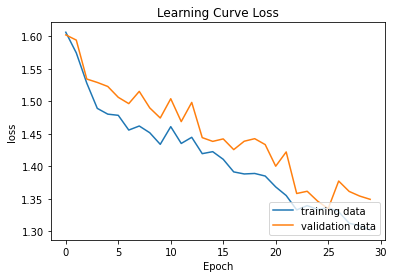

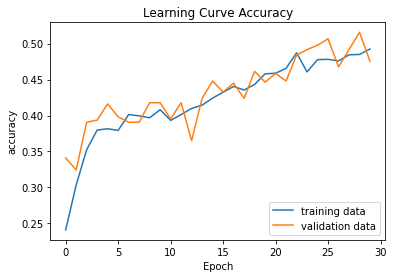

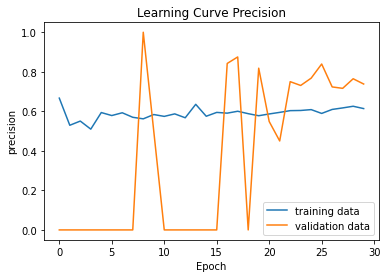

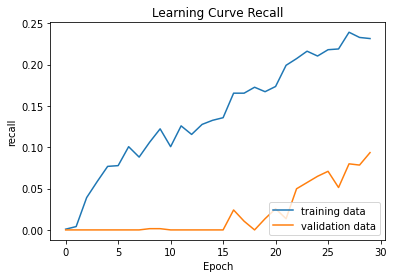

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 135, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest')


Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_149 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 62, 62, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.4475815296173096 / Test accuracy: 0.4201388955116272


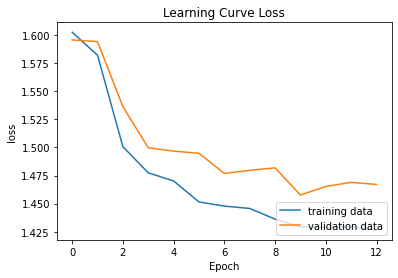

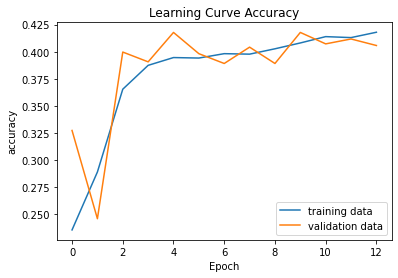

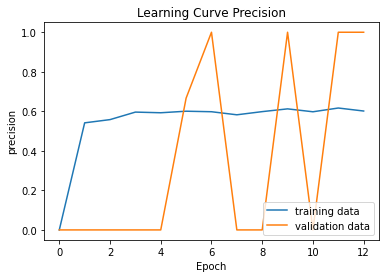

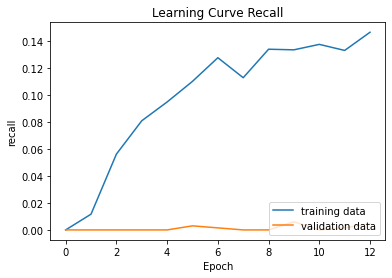

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 180, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest')


Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_155 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 62, 62, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.300001621246338 / Test accuracy: 0.5416666865348816


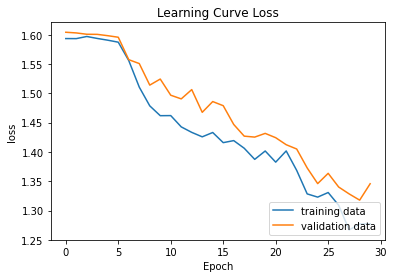

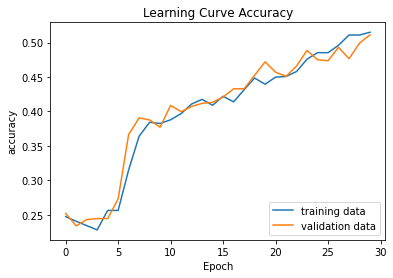

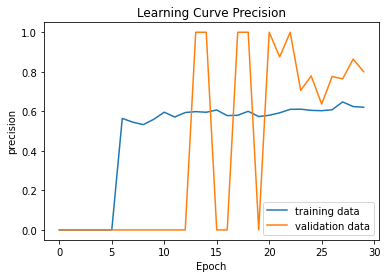

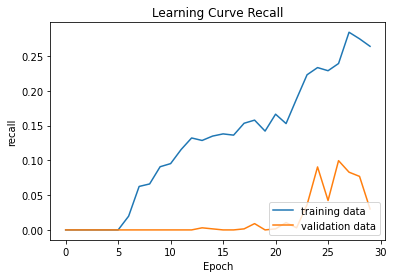

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 45, shear_range = 0.4, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest')


Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_161 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_117 (MaxPoolin (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 62, 62, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.2547078132629395 / Test accuracy: 0.5625


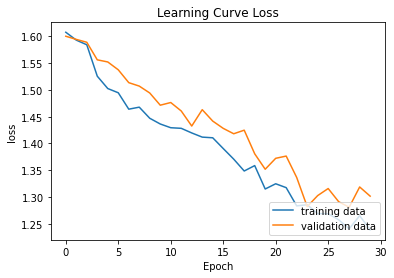

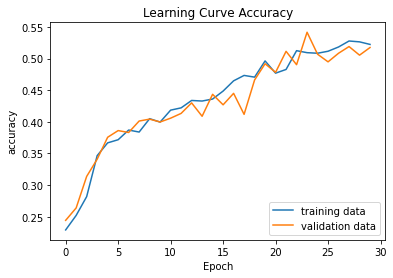

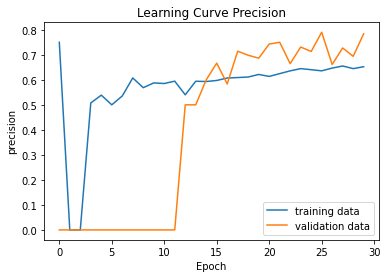

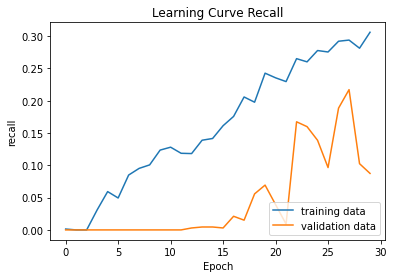

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 45, shear_range = 0.6, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest')


Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_167 (Conv2D)          (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_124 (MaxPoolin (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 62, 62, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.4273821115493774 / Test accuracy: 0.4236111044883728


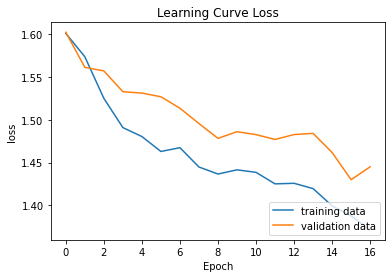

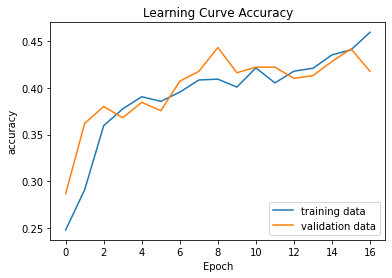

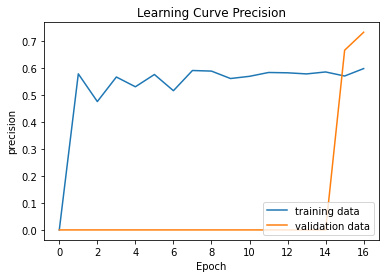

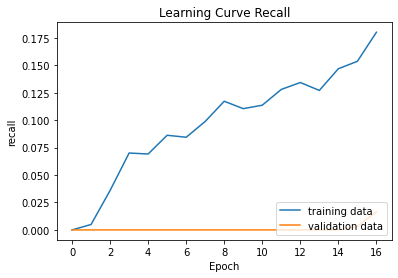

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 45, shear_range = 0.8, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest')


Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 16)        0        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.2826074361801147 / Test accuracy: 0.5243055820465088


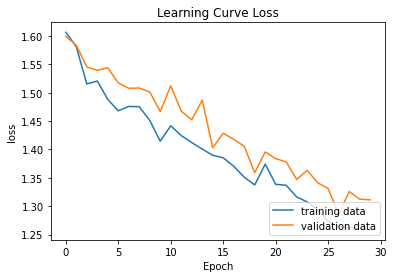

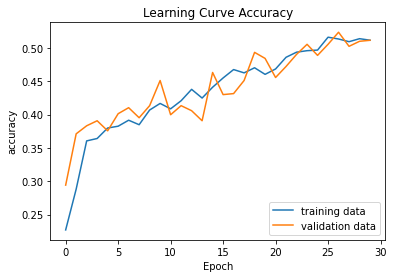

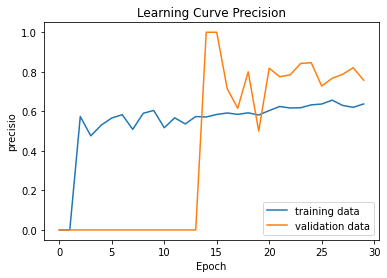

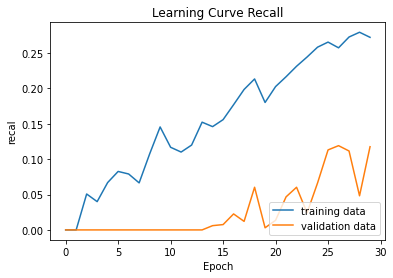

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 45, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.4, flip = True, fill = 'nearest')


Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 62, 16)        0      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.3384610414505005 / Test accuracy: 0.4583333432674408


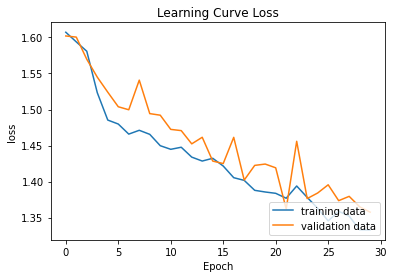

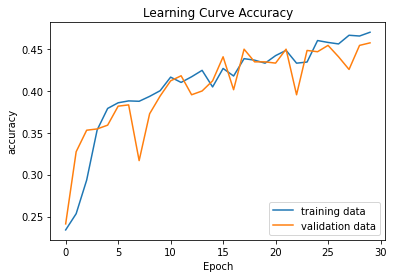

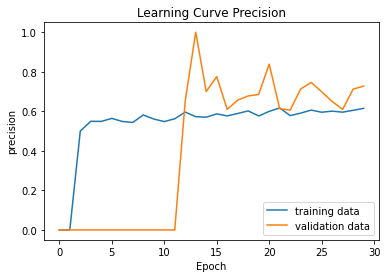

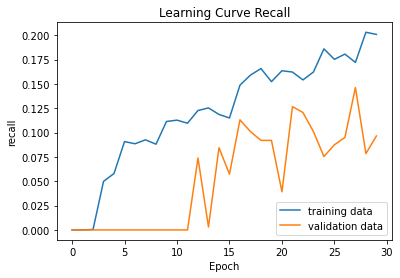

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 45, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.6, flip = True, fill = 'nearest')


Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 62, 62, 16)        0      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.3902126550674438 / Test accuracy: 0.4305555522441864


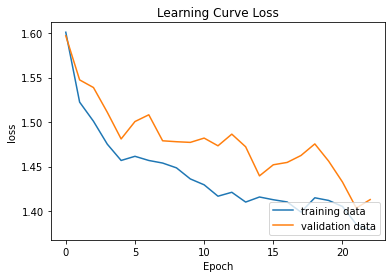

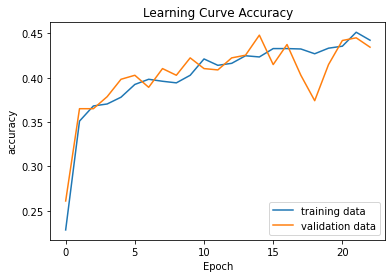

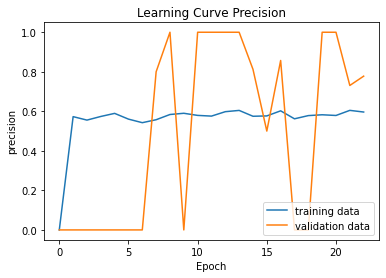

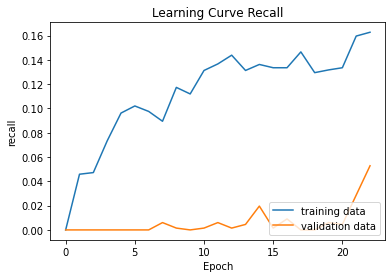

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 45, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.8, flip = True, fill = 'nearest')


#Phase V. Effects of regularization
From experiment above, the optimal solution are achieved at [16,16,16,16,16,16]
rotation = 90, zoom = 0.4, shear range = 0.6
In this section, dropout = [.25,.5,.75], L2 = [0.1,0.01,0.001], as well as batchnormalization.

In [ ]:

def get_all_generators(path, image_width, image_height,rotation = 45, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest'):
    my_generator = ImageDataGenerator(rotation_range=rotation,width_shift_range=width,
        height_shift_range=height,shear_range=shear_range,
        zoom_range=zoom,horizontal_flip=flip,
        rescale=1./255,fill_mode=fill)
    train_generator = my_generator.flow_from_directory( path+'/train/', target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
    valid_generator = my_generator.flow_from_directory( path+'/valid/', target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
    test_generator = my_generator.flow_from_directory( path+'/test/', target_size=(image_width, image_height), batch_size=32, class_mode='categorical')

    return train_generator, valid_generator, test_generator

# overfitting the model with early stop
def overfitting_early_stop(train_generator, valid_generator, test_generator, layers,image_width, image_height, dropout, L2, normalize):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, mode='max')
    model = Sequential()
    j = 0
    for i in range(len(layers)):
        if i == 0:
            model.add( Conv2D( layers[i], ( 3, 3 ), activation = 'relu' , kernel_regularizer=l2(L2), bias_regularizer=l2(L2),input_shape = (image_width, image_height, 3)))
        else:
            if normalize == True:
                model.add(BatchNormalization())
            model.add( Conv2D( layers[i], ( 3, 3 ), activation = 'relu',kernel_regularizer=l2(L2), bias_regularizer=l2(L2)))
        i += 1
        model.add( MaxPool2D(2, 2) )
        model.add(Dropout(dropout))
    model.add( Flatten() )
    model.add( Dense( 5, activation = 'softmax' ) )
    model.summary()
    model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall() ] )
    history = model.fit( train_generator, validation_data = valid_generator, epochs = 30, batch_size = 64, callbacks=[early_stopping])
    score = model.evaluate_generator(test_generator, verbose=0)
    print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    return history

# plot the learning curve, for accuracy, loss, precision, and recall 
def plot_learning_curve(history, key1, key2, ylabel, title):
    plt.plot(history.history[key1])
    plt.plot(history.history[key2])
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(['training data', 'validation data'], loc='lower right')
    plt.title(title)
    plt.show()

# test the result
def test_early_stop(path, layers,image_width, image_height, dropout=0.25, rotation = 45, shear_range = 0.2, width = 0.2, height = 0.2, zoom = 0.2, flip = True, fill = 'nearest', L2 = 0.001, normalize = False):
    train_generator, valid_generator, test_generator = get_all_generators(path, image_width, image_height,rotation = rotation, shear_range = shear_range, width = width, height = height, zoom = zoom, flip = True, fill = 'nearest')
    history = overfitting_early_stop(train_generator, valid_generator, test_generator, layers,image_width, image_height, dropout, L2, normalize)
    plot_learning_curve(history, list(history.history.keys())[0],list(history.history.keys())[4], 
                        list(history.history.keys())[0], 'Learning Curve Loss')
    plot_learning_curve(history, list(history.history.keys())[1],list(history.history.keys())[5], 
                        list(history.history.keys())[1], 'Learning Curve Accuracy')
    plot_learning_curve(history, list(history.history.keys())[2],list(history.history.keys())[6], 
                        list(history.history.keys())[2][:list(history.history.keys())[2].rfind('_')], 'Learning Curve Precision')
    plot_learning_curve(history, list(history.history.keys())[3],list(history.history.keys())[7], 
                        list(history.history.keys())[3][:list(history.history.keys())[3].rfind('_')], 'Learning Curve Recall')
    return history






Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 16)      64        
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 62, 62, 16)        0      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.5698740482330322 / Test accuracy: 0.3125


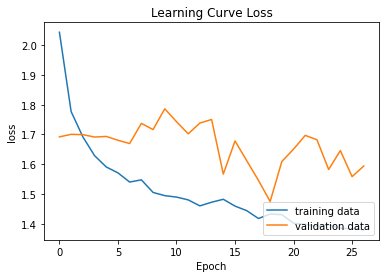

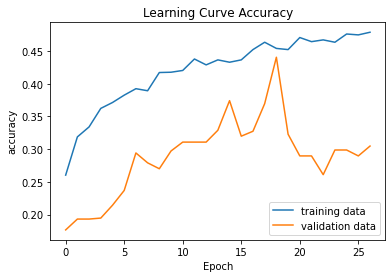

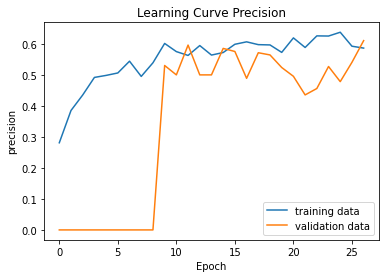

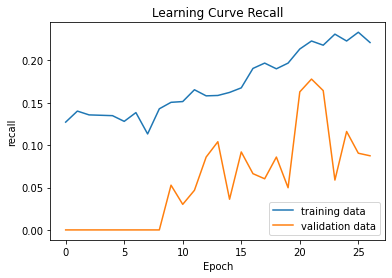

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 70, shear_range = 0.6, width = 0.2, height = 0.2, zoom = 0.4, flip = True, fill = 'nearest', normalize=True)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 62, 62, 16)        0      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.4650120735168457 / Test accuracy: 0.4166666567325592


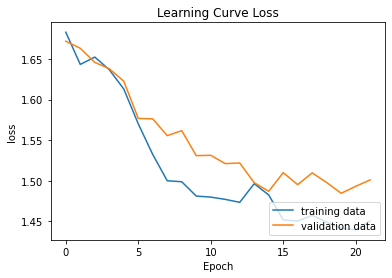

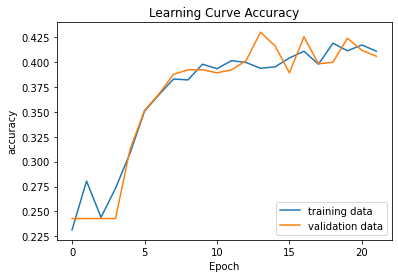

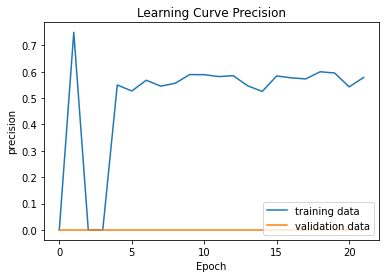

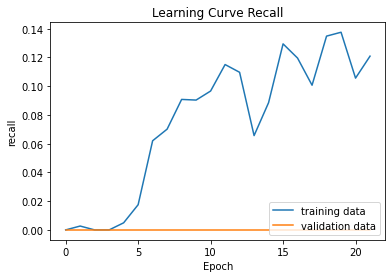

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.25, rotation = 70, shear_range = 0.6, width = 0.2, height = 0.2, zoom = 0.4, flip = True, fill = 'nearest')

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 62, 62, 16)        0      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.5108851194381714 / Test accuracy: 0.4305555522441864


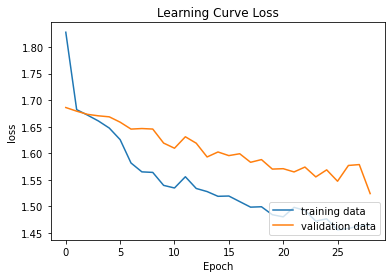

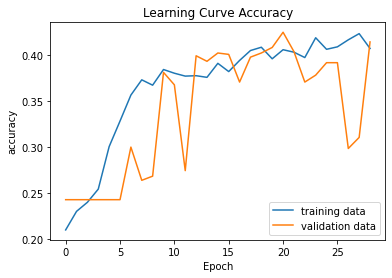

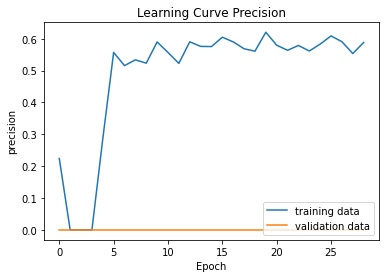

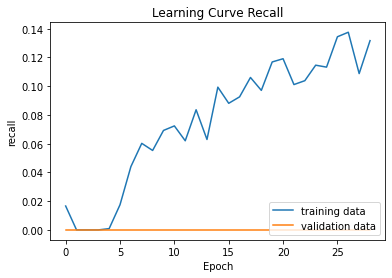

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.5, rotation = 70, shear_range = 0.6, width = 0.2, height = 0.2, zoom = 0.4, flip = True, fill = 'nearest')

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 62, 62, 16)        0      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.6714451313018799 / Test accuracy: 0.2430555522441864


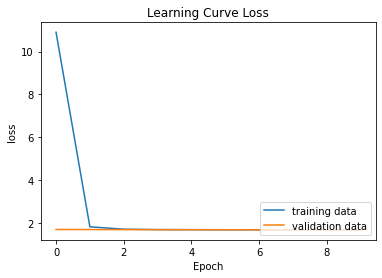

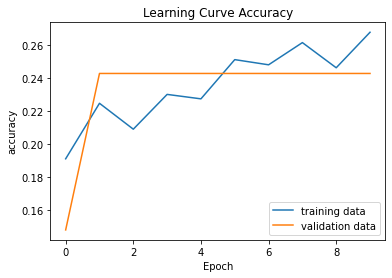

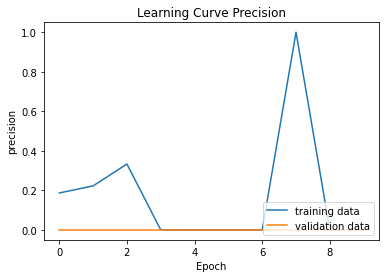

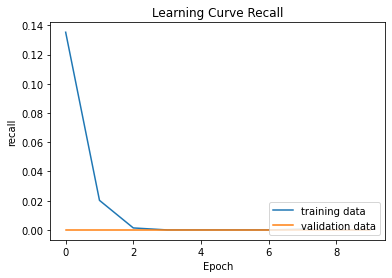

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.75, rotation = 70, shear_range = 0.6, width = 0.2, height = 0.2, zoom = 0.4, flip = True, fill = 'nearest')

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 62, 62, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.7283216714859009 / Test accuracy: 0.2430555522441864


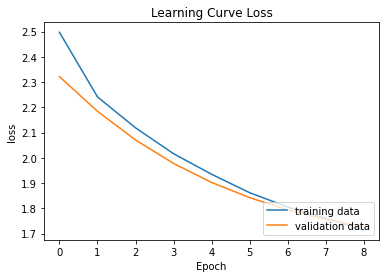

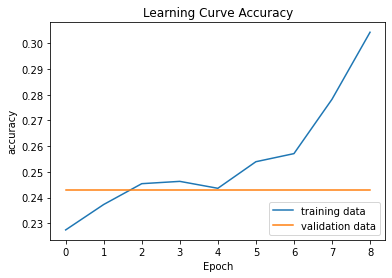

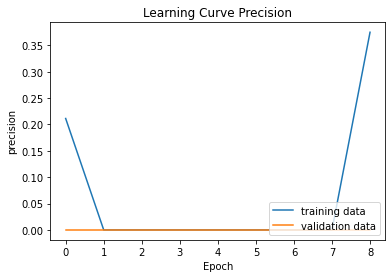

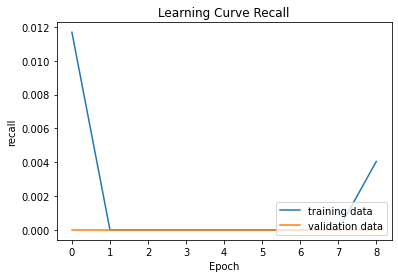

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.5, rotation = 70, shear_range = 0.6, width = 0.2, height = 0.2, zoom = 0.4, flip = True, fill = 'nearest', L2=0.01)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 62, 62, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.5989824533462524 / Test accuracy: 0.2430555522441864


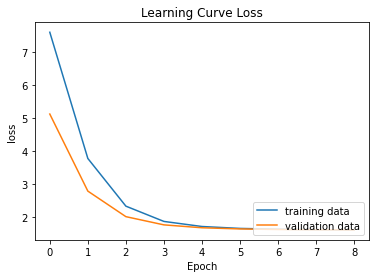

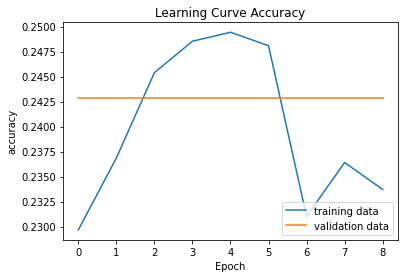

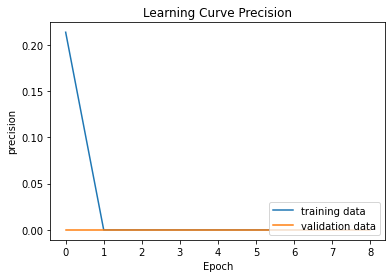

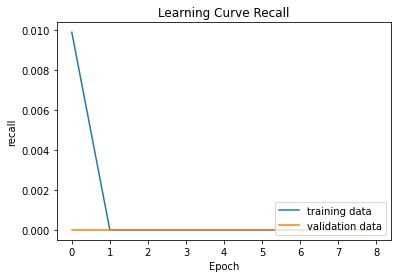

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.5, rotation = 70, shear_range = 0.6, width = 0.2, height = 0.2, zoom = 0.4, flip = True, fill = 'nearest', L2=0.1)

Found 2225 images belonging to 5 classes.
Found 663 images belonging to 5 classes.
Found 288 images belonging to 5 classes.
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 62, 62, 16)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 1.7372031211853027 / Test accuracy: 0.2430555522441864


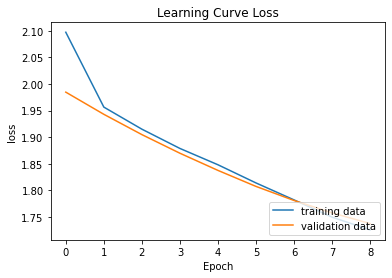

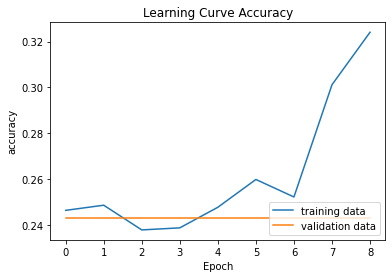

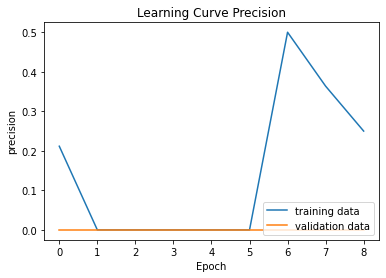

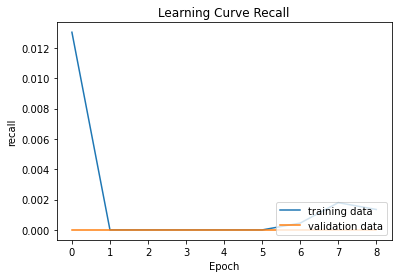

In [ ]:
test_early_stop(path, [16,16,16,16,16,16],image_width, image_height, dropout=0.5, rotation = 70, shear_range = 0.6, width = 0.2, height = 0.2, zoom = 0.4, flip = True, fill = 'nearest', L2=0.005)